In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : True,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_0_t1t2_normalized_e_n_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(2102128, 828)
(2102128, 8)
validation
(318280, 828)
(318280, 8)
test
(190288, 828)
(190288, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/211 [..............................] - ETA: 5:46 - loss: 2.2651 - STD: 0.0612 - MAE: 0.2206

  4/211 [..............................] - ETA: 4s - loss: 2.1261 - STD: 0.0494 - MAE: 0.2175  

  7/211 [..............................] - ETA: 4s - loss: 2.1110 - STD: 0.0532 - MAE: 0.2167

 10/211 [>.............................] - ETA: 4s - loss: 2.0979 - STD: 0.0480 - MAE: 0.2167

 13/211 [>.............................] - ETA: 4s - loss: 2.0871 - STD: 0.0436 - MAE: 0.2168

 16/211 [=>............................] - ETA: 4s - loss: 2.0804 - STD: 0.0420 - MAE: 0.2167

 19/211 [=>............................] - ETA: 4s - loss: 2.0749 - STD: 0.0406 - MAE: 0.2167

 22/211 [==>...........................] - ETA: 4s - loss: 2.0677 - STD: 0.0391 - MAE: 0.2166

 25/211 [==>...........................] - ETA: 4s - loss: 2.0600 - STD: 0.0388 - MAE: 0.2164

 28/211 [==>...........................] - ETA: 4s - loss: 2.0505 - STD: 0.0391 - MAE: 0.2160

 31/211 [===>..........................] - ETA: 4s - loss: 2.0392 - STD: 0.0400 - MAE: 0.2156

 34/211 [===>..........................] - ETA: 3s - loss: 2.0261 - STD: 0.0416 - MAE: 0.2151

 37/211 [====>.........................] - ETA: 3s - loss: 2.0127 - STD: 0.0438 - MAE: 0.2144

 40/211 [====>.........................] - ETA: 3s - loss: 1.9994 - STD: 0.0463 - MAE: 0.2137

 43/211 [=====>........................] - ETA: 3s - loss: 1.9870 - STD: 0.0488 - MAE: 0.2131

 46/211 [=====>........................] - ETA: 3s - loss: 1.9747 - STD: 0.0511 - MAE: 0.2124

 49/211 [=====>........................] - ETA: 3s - loss: 1.9628 - STD: 0.0533 - MAE: 0.2118

 52/211 [======>.......................] - ETA: 3s - loss: 1.9518 - STD: 0.0553 - MAE: 0.2112

 55/211 [======>.......................] - ETA: 3s - loss: 1.9407 - STD: 0.0572 - MAE: 0.2107

 58/211 [=======>......................] - ETA: 3s - loss: 1.9301 - STD: 0.0589 - MAE: 0.2101

 61/211 [=======>......................] - ETA: 3s - loss: 1.9194 - STD: 0.0606 - MAE: 0.2096

 64/211 [========>.....................] - ETA: 3s - loss: 1.9091 - STD: 0.0623 - MAE: 0.2091

 67/211 [========>.....................] - ETA: 3s - loss: 1.8988 - STD: 0.0640 - MAE: 0.2086

 70/211 [========>.....................] - ETA: 3s - loss: 1.8885 - STD: 0.0655 - MAE: 0.2080

 73/211 [=========>....................] - ETA: 3s - loss: 1.8782 - STD: 0.0671 - MAE: 0.2075

 76/211 [=========>....................] - ETA: 3s - loss: 1.8680 - STD: 0.0685 - MAE: 0.2070

 79/211 [==========>...................] - ETA: 2s - loss: 1.8579 - STD: 0.0699 - MAE: 0.2065

 82/211 [==========>...................] - ETA: 2s - loss: 1.8480 - STD: 0.0713 - MAE: 0.2060

 85/211 [===========>..................] - ETA: 2s - loss: 1.8389 - STD: 0.0728 - MAE: 0.2054

 88/211 [===========>..................] - ETA: 2s - loss: 1.8297 - STD: 0.0742 - MAE: 0.2049

 91/211 [===========>..................] - ETA: 2s - loss: 1.8205 - STD: 0.0756 - MAE: 0.2044

 94/211 [============>.................] - ETA: 2s - loss: 1.8118 - STD: 0.0770 - MAE: 0.2038

 97/211 [============>.................] - ETA: 2s - loss: 1.8033 - STD: 0.0784 - MAE: 0.2033

100/211 [=============>................] - ETA: 2s - loss: 1.7949 - STD: 0.0798 - MAE: 0.2027

103/211 [=============>................] - ETA: 2s - loss: 1.7867 - STD: 0.0812 - MAE: 0.2022

106/211 [==============>...............] - ETA: 2s - loss: 1.7789 - STD: 0.0826 - MAE: 0.2016

109/211 [==============>...............] - ETA: 2s - loss: 1.7711 - STD: 0.0840 - MAE: 0.2011

112/211 [==============>...............] - ETA: 2s - loss: 1.7636 - STD: 0.0853 - MAE: 0.2006

115/211 [===============>..............] - ETA: 2s - loss: 1.7563 - STD: 0.0865 - MAE: 0.2001

118/211 [===============>..............] - ETA: 2s - loss: 1.7491 - STD: 0.0877 - MAE: 0.1996

121/211 [================>.............] - ETA: 2s - loss: 1.7418 - STD: 0.0888 - MAE: 0.1991

124/211 [================>.............] - ETA: 1s - loss: 1.7350 - STD: 0.0900 - MAE: 0.1986

127/211 [=================>............] - ETA: 1s - loss: 1.7281 - STD: 0.0911 - MAE: 0.1981

130/211 [=================>............] - ETA: 1s - loss: 1.7212 - STD: 0.0922 - MAE: 0.1976

133/211 [=================>............] - ETA: 1s - loss: 1.7141 - STD: 0.0933 - MAE: 0.1972

136/211 [==================>...........] - ETA: 1s - loss: 1.7073 - STD: 0.0943 - MAE: 0.1967

139/211 [==================>...........] - ETA: 1s - loss: 1.7005 - STD: 0.0954 - MAE: 0.1962

142/211 [===================>..........] - ETA: 1s - loss: 1.6937 - STD: 0.0965 - MAE: 0.1957

145/211 [===================>..........] - ETA: 1s - loss: 1.6868 - STD: 0.0975 - MAE: 0.1952

148/211 [====================>.........] - ETA: 1s - loss: 1.6800 - STD: 0.0986 - MAE: 0.1947

151/211 [====================>.........] - ETA: 1s - loss: 1.6733 - STD: 0.0996 - MAE: 0.1942

154/211 [====================>.........] - ETA: 1s - loss: 1.6669 - STD: 0.1007 - MAE: 0.1937

157/211 [=====================>........] - ETA: 1s - loss: 1.6606 - STD: 0.1018 - MAE: 0.1932

160/211 [=====================>........] - ETA: 1s - loss: 1.6545 - STD: 0.1028 - MAE: 0.1927

163/211 [======================>.......] - ETA: 1s - loss: 1.6486 - STD: 0.1038 - MAE: 0.1922

166/211 [======================>.......] - ETA: 1s - loss: 1.6428 - STD: 0.1048 - MAE: 0.1917

169/211 [=======================>......] - ETA: 0s - loss: 1.6371 - STD: 0.1057 - MAE: 0.1913

172/211 [=======================>......] - ETA: 0s - loss: 1.6315 - STD: 0.1067 - MAE: 0.1908

175/211 [=======================>......] - ETA: 0s - loss: 1.6260 - STD: 0.1076 - MAE: 0.1904

178/211 [========================>.....] - ETA: 0s - loss: 1.6207 - STD: 0.1085 - MAE: 0.1899

181/211 [========================>.....] - ETA: 0s - loss: 1.6153 - STD: 0.1095 - MAE: 0.1895

184/211 [=========================>....] - ETA: 0s - loss: 1.6102 - STD: 0.1103 - MAE: 0.1891

187/211 [=========================>....] - ETA: 0s - loss: 1.6051 - STD: 0.1112 - MAE: 0.1887

189/211 [=========================>....] - ETA: 0s - loss: 1.6031 - STD: 0.1117 - MAE: 0.1884

192/211 [==========================>...] - ETA: 0s - loss: 1.5982 - STD: 0.1126 - MAE: 0.1880

195/211 [==========================>...] - ETA: 0s - loss: 1.5934 - STD: 0.1134 - MAE: 0.1876

198/211 [===========================>..] - ETA: 0s - loss: 1.5887 - STD: 0.1142 - MAE: 0.1872

201/211 [===========================>..] - ETA: 0s - loss: 1.5841 - STD: 0.1150 - MAE: 0.1868

204/211 [============================>.] - ETA: 0s - loss: 1.5795 - STD: 0.1157 - MAE: 0.1864

207/211 [============================>.] - ETA: 0s - loss: 1.5752 - STD: 0.1164 - MAE: 0.1861

210/211 [============================>.] - ETA: 0s - loss: 1.5707 - STD: 0.1172 - MAE: 0.1857

211/211 [==============================] - 8s 32ms/step - loss: 1.5694 - STD: 0.1174 - MAE: 0.1856 - val_loss: 1.3109 - val_STD: 0.1666 - val_MAE: 0.1614


Epoch 2/10000


  1/211 [..............................] - ETA: 9s - loss: 1.2824 - STD: 0.1690 - MAE: 0.1606

  4/211 [..............................] - ETA: 4s - loss: 1.2751 - STD: 0.1693 - MAE: 0.1602

  7/211 [..............................] - ETA: 4s - loss: 1.2756 - STD: 0.1690 - MAE: 0.1602

 10/211 [>.............................] - ETA: 4s - loss: 1.2739 - STD: 0.1687 - MAE: 0.1603

 13/211 [>.............................] - ETA: 4s - loss: 1.2715 - STD: 0.1687 - MAE: 0.1602

 16/211 [=>............................] - ETA: 4s - loss: 1.2700 - STD: 0.1689 - MAE: 0.1600

 19/211 [=>............................] - ETA: 4s - loss: 1.2690 - STD: 0.1691 - MAE: 0.1599

 22/211 [==>...........................] - ETA: 4s - loss: 1.2670 - STD: 0.1695 - MAE: 0.1597

 25/211 [==>...........................] - ETA: 4s - loss: 1.2657 - STD: 0.1697 - MAE: 0.1595

 28/211 [==>...........................] - ETA: 4s - loss: 1.2637 - STD: 0.1699 - MAE: 0.1594

 31/211 [===>..........................] - ETA: 4s - loss: 1.2625 - STD: 0.1701 - MAE: 0.1592

 34/211 [===>..........................] - ETA: 4s - loss: 1.2620 - STD: 0.1703 - MAE: 0.1592

 37/211 [====>.........................] - ETA: 4s - loss: 1.2609 - STD: 0.1704 - MAE: 0.1591

 40/211 [====>.........................] - ETA: 3s - loss: 1.2599 - STD: 0.1706 - MAE: 0.1590

 43/211 [=====>........................] - ETA: 3s - loss: 1.2593 - STD: 0.1707 - MAE: 0.1589

 46/211 [=====>........................] - ETA: 3s - loss: 1.2586 - STD: 0.1708 - MAE: 0.1588

 49/211 [=====>........................] - ETA: 3s - loss: 1.2578 - STD: 0.1709 - MAE: 0.1587

 52/211 [======>.......................] - ETA: 3s - loss: 1.2564 - STD: 0.1711 - MAE: 0.1586

 55/211 [======>.......................] - ETA: 3s - loss: 1.2550 - STD: 0.1713 - MAE: 0.1585

 58/211 [=======>......................] - ETA: 3s - loss: 1.2543 - STD: 0.1714 - MAE: 0.1584

 61/211 [=======>......................] - ETA: 3s - loss: 1.2532 - STD: 0.1716 - MAE: 0.1583

 64/211 [========>.....................] - ETA: 3s - loss: 1.2527 - STD: 0.1717 - MAE: 0.1582

 67/211 [========>.....................] - ETA: 3s - loss: 1.2522 - STD: 0.1719 - MAE: 0.1581

 70/211 [========>.....................] - ETA: 3s - loss: 1.2517 - STD: 0.1720 - MAE: 0.1581

 73/211 [=========>....................] - ETA: 3s - loss: 1.2510 - STD: 0.1722 - MAE: 0.1580

 76/211 [=========>....................] - ETA: 3s - loss: 1.2497 - STD: 0.1723 - MAE: 0.1579

 79/211 [==========>...................] - ETA: 3s - loss: 1.2487 - STD: 0.1724 - MAE: 0.1578

 82/211 [==========>...................] - ETA: 2s - loss: 1.2479 - STD: 0.1726 - MAE: 0.1577

 85/211 [===========>..................] - ETA: 2s - loss: 1.2471 - STD: 0.1727 - MAE: 0.1576

 88/211 [===========>..................] - ETA: 2s - loss: 1.2457 - STD: 0.1729 - MAE: 0.1575

 91/211 [===========>..................] - ETA: 2s - loss: 1.2449 - STD: 0.1730 - MAE: 0.1574

 94/211 [============>.................] - ETA: 2s - loss: 1.2439 - STD: 0.1732 - MAE: 0.1573

 97/211 [============>.................] - ETA: 2s - loss: 1.2431 - STD: 0.1733 - MAE: 0.1572

100/211 [=============>................] - ETA: 2s - loss: 1.2424 - STD: 0.1734 - MAE: 0.1571

103/211 [=============>................] - ETA: 2s - loss: 1.2415 - STD: 0.1735 - MAE: 0.1571

106/211 [==============>...............] - ETA: 2s - loss: 1.2405 - STD: 0.1736 - MAE: 0.1570

109/211 [==============>...............] - ETA: 2s - loss: 1.2397 - STD: 0.1738 - MAE: 0.1569

112/211 [==============>...............] - ETA: 2s - loss: 1.2390 - STD: 0.1739 - MAE: 0.1568

115/211 [===============>..............] - ETA: 2s - loss: 1.2382 - STD: 0.1740 - MAE: 0.1567

118/211 [===============>..............] - ETA: 2s - loss: 1.2373 - STD: 0.1742 - MAE: 0.1566

121/211 [================>.............] - ETA: 2s - loss: 1.2362 - STD: 0.1743 - MAE: 0.1565

124/211 [================>.............] - ETA: 1s - loss: 1.2360 - STD: 0.1744 - MAE: 0.1565

127/211 [=================>............] - ETA: 1s - loss: 1.2350 - STD: 0.1746 - MAE: 0.1564

130/211 [=================>............] - ETA: 1s - loss: 1.2343 - STD: 0.1747 - MAE: 0.1563

133/211 [=================>............] - ETA: 1s - loss: 1.2338 - STD: 0.1748 - MAE: 0.1562

136/211 [==================>...........] - ETA: 1s - loss: 1.2331 - STD: 0.1749 - MAE: 0.1562

139/211 [==================>...........] - ETA: 1s - loss: 1.2325 - STD: 0.1750 - MAE: 0.1561

142/211 [===================>..........] - ETA: 1s - loss: 1.2317 - STD: 0.1751 - MAE: 0.1560

145/211 [===================>..........] - ETA: 1s - loss: 1.2309 - STD: 0.1752 - MAE: 0.1559

148/211 [====================>.........] - ETA: 1s - loss: 1.2304 - STD: 0.1754 - MAE: 0.1559

151/211 [====================>.........] - ETA: 1s - loss: 1.2295 - STD: 0.1755 - MAE: 0.1558

154/211 [====================>.........] - ETA: 1s - loss: 1.2287 - STD: 0.1756 - MAE: 0.1557

157/211 [=====================>........] - ETA: 1s - loss: 1.2279 - STD: 0.1757 - MAE: 0.1556

160/211 [=====================>........] - ETA: 1s - loss: 1.2270 - STD: 0.1758 - MAE: 0.1555

163/211 [======================>.......] - ETA: 1s - loss: 1.2261 - STD: 0.1759 - MAE: 0.1555

166/211 [======================>.......] - ETA: 1s - loss: 1.2253 - STD: 0.1760 - MAE: 0.1554

169/211 [=======================>......] - ETA: 0s - loss: 1.2245 - STD: 0.1761 - MAE: 0.1553

172/211 [=======================>......] - ETA: 0s - loss: 1.2238 - STD: 0.1762 - MAE: 0.1552

175/211 [=======================>......] - ETA: 0s - loss: 1.2230 - STD: 0.1764 - MAE: 0.1551

178/211 [========================>.....] - ETA: 0s - loss: 1.2221 - STD: 0.1765 - MAE: 0.1551

181/211 [========================>.....] - ETA: 0s - loss: 1.2213 - STD: 0.1766 - MAE: 0.1550

184/211 [=========================>....] - ETA: 0s - loss: 1.2206 - STD: 0.1767 - MAE: 0.1549

187/211 [=========================>....] - ETA: 0s - loss: 1.2200 - STD: 0.1768 - MAE: 0.1548

190/211 [==========================>...] - ETA: 0s - loss: 1.2195 - STD: 0.1769 - MAE: 0.1547

193/211 [==========================>...] - ETA: 0s - loss: 1.2190 - STD: 0.1770 - MAE: 0.1547

196/211 [==========================>...] - ETA: 0s - loss: 1.2183 - STD: 0.1771 - MAE: 0.1546

199/211 [===========================>..] - ETA: 0s - loss: 1.2176 - STD: 0.1773 - MAE: 0.1545

202/211 [===========================>..] - ETA: 0s - loss: 1.2170 - STD: 0.1774 - MAE: 0.1545

205/211 [============================>.] - ETA: 0s - loss: 1.2163 - STD: 0.1775 - MAE: 0.1544

208/211 [============================>.] - ETA: 0s - loss: 1.2155 - STD: 0.1775 - MAE: 0.1543

211/211 [==============================] - ETA: 0s - loss: 1.2148 - STD: 0.1776 - MAE: 0.1543

211/211 [==============================] - 5s 26ms/step - loss: 1.2148 - STD: 0.1776 - MAE: 0.1543 - val_loss: 1.2052 - val_STD: 0.1841 - val_MAE: 0.1511


Epoch 3/10000


  1/211 [..............................] - ETA: 11s - loss: 1.1657 - STD: 0.1861 - MAE: 0.1486

  4/211 [..............................] - ETA: 4s - loss: 1.1690 - STD: 0.1855 - MAE: 0.1492 

  7/211 [..............................] - ETA: 4s - loss: 1.1668 - STD: 0.1852 - MAE: 0.1492

 10/211 [>.............................] - ETA: 4s - loss: 1.1638 - STD: 0.1853 - MAE: 0.1489

 13/211 [>.............................] - ETA: 4s - loss: 1.1609 - STD: 0.1853 - MAE: 0.1488

 16/211 [=>............................] - ETA: 4s - loss: 1.1575 - STD: 0.1855 - MAE: 0.1485

 19/211 [=>............................] - ETA: 4s - loss: 1.1581 - STD: 0.1853 - MAE: 0.1486

 22/211 [==>...........................] - ETA: 4s - loss: 1.1603 - STD: 0.1854 - MAE: 0.1487

 25/211 [==>...........................] - ETA: 4s - loss: 1.1600 - STD: 0.1855 - MAE: 0.1486

 28/211 [==>...........................] - ETA: 4s - loss: 1.1605 - STD: 0.1855 - MAE: 0.1487

 31/211 [===>..........................] - ETA: 4s - loss: 1.1614 - STD: 0.1855 - MAE: 0.1487

 34/211 [===>..........................] - ETA: 4s - loss: 1.1606 - STD: 0.1856 - MAE: 0.1487

 37/211 [====>.........................] - ETA: 4s - loss: 1.1594 - STD: 0.1857 - MAE: 0.1485

 40/211 [====>.........................] - ETA: 3s - loss: 1.1592 - STD: 0.1859 - MAE: 0.1485

 43/211 [=====>........................] - ETA: 3s - loss: 1.1590 - STD: 0.1859 - MAE: 0.1484

 46/211 [=====>........................] - ETA: 3s - loss: 1.1591 - STD: 0.1860 - MAE: 0.1485

 49/211 [=====>........................] - ETA: 3s - loss: 1.1587 - STD: 0.1859 - MAE: 0.1484

 52/211 [======>.......................] - ETA: 3s - loss: 1.1579 - STD: 0.1860 - MAE: 0.1484

 55/211 [======>.......................] - ETA: 3s - loss: 1.1570 - STD: 0.1861 - MAE: 0.1483

 58/211 [=======>......................] - ETA: 3s - loss: 1.1562 - STD: 0.1862 - MAE: 0.1482

 61/211 [=======>......................] - ETA: 3s - loss: 1.1553 - STD: 0.1862 - MAE: 0.1481

 64/211 [========>.....................] - ETA: 3s - loss: 1.1545 - STD: 0.1863 - MAE: 0.1481

 67/211 [========>.....................] - ETA: 3s - loss: 1.1538 - STD: 0.1864 - MAE: 0.1480

 70/211 [========>.....................] - ETA: 3s - loss: 1.1535 - STD: 0.1865 - MAE: 0.1480

 73/211 [=========>....................] - ETA: 3s - loss: 1.1531 - STD: 0.1866 - MAE: 0.1479

 76/211 [=========>....................] - ETA: 3s - loss: 1.1523 - STD: 0.1866 - MAE: 0.1478

 79/211 [==========>...................] - ETA: 3s - loss: 1.1531 - STD: 0.1866 - MAE: 0.1479

 82/211 [==========>...................] - ETA: 3s - loss: 1.1544 - STD: 0.1867 - MAE: 0.1479

 85/211 [===========>..................] - ETA: 2s - loss: 1.1542 - STD: 0.1867 - MAE: 0.1479

 88/211 [===========>..................] - ETA: 2s - loss: 1.1538 - STD: 0.1868 - MAE: 0.1479

 91/211 [===========>..................] - ETA: 2s - loss: 1.1537 - STD: 0.1868 - MAE: 0.1478

 94/211 [============>.................] - ETA: 2s - loss: 1.1531 - STD: 0.1869 - MAE: 0.1478

 97/211 [============>.................] - ETA: 2s - loss: 1.1526 - STD: 0.1869 - MAE: 0.1477

100/211 [=============>................] - ETA: 2s - loss: 1.1521 - STD: 0.1870 - MAE: 0.1477

103/211 [=============>................] - ETA: 2s - loss: 1.1517 - STD: 0.1871 - MAE: 0.1476

106/211 [==============>...............] - ETA: 2s - loss: 1.1511 - STD: 0.1871 - MAE: 0.1476

109/211 [==============>...............] - ETA: 2s - loss: 1.1505 - STD: 0.1871 - MAE: 0.1475

112/211 [==============>...............] - ETA: 2s - loss: 1.1506 - STD: 0.1871 - MAE: 0.1475

115/211 [===============>..............] - ETA: 2s - loss: 1.1501 - STD: 0.1872 - MAE: 0.1475

118/211 [===============>..............] - ETA: 2s - loss: 1.1501 - STD: 0.1873 - MAE: 0.1475

121/211 [================>.............] - ETA: 2s - loss: 1.1502 - STD: 0.1874 - MAE: 0.1474

124/211 [================>.............] - ETA: 2s - loss: 1.1499 - STD: 0.1874 - MAE: 0.1474

127/211 [=================>............] - ETA: 1s - loss: 1.1494 - STD: 0.1875 - MAE: 0.1474

130/211 [=================>............] - ETA: 1s - loss: 1.1490 - STD: 0.1875 - MAE: 0.1473

133/211 [=================>............] - ETA: 1s - loss: 1.1483 - STD: 0.1875 - MAE: 0.1473

136/211 [==================>...........] - ETA: 1s - loss: 1.1478 - STD: 0.1876 - MAE: 0.1472

139/211 [==================>...........] - ETA: 1s - loss: 1.1473 - STD: 0.1876 - MAE: 0.1472

142/211 [===================>..........] - ETA: 1s - loss: 1.1466 - STD: 0.1877 - MAE: 0.1471

145/211 [===================>..........] - ETA: 1s - loss: 1.1462 - STD: 0.1877 - MAE: 0.1471

148/211 [====================>.........] - ETA: 1s - loss: 1.1458 - STD: 0.1878 - MAE: 0.1470

151/211 [====================>.........] - ETA: 1s - loss: 1.1451 - STD: 0.1878 - MAE: 0.1470

154/211 [====================>.........] - ETA: 1s - loss: 1.1449 - STD: 0.1879 - MAE: 0.1470

157/211 [=====================>........] - ETA: 1s - loss: 1.1444 - STD: 0.1879 - MAE: 0.1469

160/211 [=====================>........] - ETA: 1s - loss: 1.1438 - STD: 0.1880 - MAE: 0.1469

163/211 [======================>.......] - ETA: 1s - loss: 1.1433 - STD: 0.1881 - MAE: 0.1468

166/211 [======================>.......] - ETA: 1s - loss: 1.1426 - STD: 0.1881 - MAE: 0.1467

169/211 [=======================>......] - ETA: 0s - loss: 1.1420 - STD: 0.1882 - MAE: 0.1467

172/211 [=======================>......] - ETA: 0s - loss: 1.1413 - STD: 0.1883 - MAE: 0.1466

175/211 [=======================>......] - ETA: 0s - loss: 1.1406 - STD: 0.1883 - MAE: 0.1465

178/211 [========================>.....] - ETA: 0s - loss: 1.1400 - STD: 0.1884 - MAE: 0.1465

181/211 [========================>.....] - ETA: 0s - loss: 1.1396 - STD: 0.1885 - MAE: 0.1464

184/211 [=========================>....] - ETA: 0s - loss: 1.1396 - STD: 0.1885 - MAE: 0.1464

187/211 [=========================>....] - ETA: 0s - loss: 1.1395 - STD: 0.1886 - MAE: 0.1464

190/211 [==========================>...] - ETA: 0s - loss: 1.1392 - STD: 0.1887 - MAE: 0.1463

193/211 [==========================>...] - ETA: 0s - loss: 1.1390 - STD: 0.1887 - MAE: 0.1463

196/211 [==========================>...] - ETA: 0s - loss: 1.1385 - STD: 0.1887 - MAE: 0.1463

199/211 [===========================>..] - ETA: 0s - loss: 1.1380 - STD: 0.1888 - MAE: 0.1462

202/211 [===========================>..] - ETA: 0s - loss: 1.1375 - STD: 0.1889 - MAE: 0.1461

205/211 [============================>.] - ETA: 0s - loss: 1.1370 - STD: 0.1889 - MAE: 0.1461

208/211 [============================>.] - ETA: 0s - loss: 1.1364 - STD: 0.1890 - MAE: 0.1460

211/211 [==============================] - ETA: 0s - loss: 1.1359 - STD: 0.1890 - MAE: 0.1460

211/211 [==============================] - 6s 26ms/step - loss: 1.1359 - STD: 0.1890 - MAE: 0.1460 - val_loss: 1.1269 - val_STD: 0.1918 - val_MAE: 0.1445


Epoch 4/10000


  1/211 [..............................] - ETA: 12s - loss: 1.0995 - STD: 0.1913 - MAE: 0.1430

  3/211 [..............................] - ETA: 5s - loss: 1.0892 - STD: 0.1921 - MAE: 0.1421 

  6/211 [..............................] - ETA: 5s - loss: 1.0930 - STD: 0.1924 - MAE: 0.1422

  9/211 [>.............................] - ETA: 4s - loss: 1.0915 - STD: 0.1928 - MAE: 0.1421

 12/211 [>.............................] - ETA: 4s - loss: 1.0902 - STD: 0.1931 - MAE: 0.1419

 15/211 [=>............................] - ETA: 4s - loss: 1.0930 - STD: 0.1934 - MAE: 0.1419

 18/211 [=>............................] - ETA: 4s - loss: 1.0960 - STD: 0.1935 - MAE: 0.1420

 21/211 [=>............................] - ETA: 4s - loss: 1.0949 - STD: 0.1936 - MAE: 0.1419

 24/211 [==>...........................] - ETA: 4s - loss: 1.0950 - STD: 0.1934 - MAE: 0.1420

 27/211 [==>...........................] - ETA: 4s - loss: 1.0928 - STD: 0.1934 - MAE: 0.1419

 30/211 [===>..........................] - ETA: 4s - loss: 1.0970 - STD: 0.1937 - MAE: 0.1420

 33/211 [===>..........................] - ETA: 4s - loss: 1.0997 - STD: 0.1938 - MAE: 0.1421

 36/211 [====>.........................] - ETA: 4s - loss: 1.0991 - STD: 0.1938 - MAE: 0.1420

 39/211 [====>.........................] - ETA: 4s - loss: 1.0970 - STD: 0.1939 - MAE: 0.1419

 42/211 [====>.........................] - ETA: 3s - loss: 1.0957 - STD: 0.1941 - MAE: 0.1417

 45/211 [=====>........................] - ETA: 3s - loss: 1.0949 - STD: 0.1942 - MAE: 0.1417

 48/211 [=====>........................] - ETA: 3s - loss: 1.0938 - STD: 0.1943 - MAE: 0.1416

 51/211 [======>.......................] - ETA: 3s - loss: 1.0929 - STD: 0.1943 - MAE: 0.1415

 54/211 [======>.......................] - ETA: 3s - loss: 1.0920 - STD: 0.1944 - MAE: 0.1414

 57/211 [=======>......................] - ETA: 3s - loss: 1.0915 - STD: 0.1945 - MAE: 0.1413

 60/211 [=======>......................] - ETA: 3s - loss: 1.0908 - STD: 0.1945 - MAE: 0.1413

 63/211 [=======>......................] - ETA: 3s - loss: 1.0904 - STD: 0.1946 - MAE: 0.1412

 66/211 [========>.....................] - ETA: 3s - loss: 1.0893 - STD: 0.1947 - MAE: 0.1411

 69/211 [========>.....................] - ETA: 3s - loss: 1.0889 - STD: 0.1948 - MAE: 0.1411

 72/211 [=========>....................] - ETA: 3s - loss: 1.0882 - STD: 0.1949 - MAE: 0.1410

 75/211 [=========>....................] - ETA: 3s - loss: 1.0875 - STD: 0.1950 - MAE: 0.1409

 78/211 [==========>...................] - ETA: 3s - loss: 1.0868 - STD: 0.1951 - MAE: 0.1408

 81/211 [==========>...................] - ETA: 3s - loss: 1.0860 - STD: 0.1952 - MAE: 0.1407

 84/211 [==========>...................] - ETA: 2s - loss: 1.0857 - STD: 0.1953 - MAE: 0.1407

 87/211 [===========>..................] - ETA: 2s - loss: 1.0855 - STD: 0.1954 - MAE: 0.1406

 90/211 [===========>..................] - ETA: 2s - loss: 1.0850 - STD: 0.1955 - MAE: 0.1406

 93/211 [============>.................] - ETA: 2s - loss: 1.0846 - STD: 0.1956 - MAE: 0.1405

 96/211 [============>.................] - ETA: 2s - loss: 1.0840 - STD: 0.1956 - MAE: 0.1404

 99/211 [=============>................] - ETA: 2s - loss: 1.0834 - STD: 0.1957 - MAE: 0.1404

102/211 [=============>................] - ETA: 2s - loss: 1.0828 - STD: 0.1957 - MAE: 0.1403

105/211 [=============>................] - ETA: 2s - loss: 1.0821 - STD: 0.1958 - MAE: 0.1402

108/211 [==============>...............] - ETA: 2s - loss: 1.0836 - STD: 0.1960 - MAE: 0.1403

111/211 [==============>...............] - ETA: 2s - loss: 1.0845 - STD: 0.1960 - MAE: 0.1403

114/211 [===============>..............] - ETA: 2s - loss: 1.0846 - STD: 0.1961 - MAE: 0.1403

117/211 [===============>..............] - ETA: 2s - loss: 1.0842 - STD: 0.1962 - MAE: 0.1402

120/211 [================>.............] - ETA: 2s - loss: 1.0838 - STD: 0.1962 - MAE: 0.1402

123/211 [================>.............] - ETA: 2s - loss: 1.0833 - STD: 0.1963 - MAE: 0.1401

126/211 [================>.............] - ETA: 1s - loss: 1.0828 - STD: 0.1963 - MAE: 0.1401

129/211 [=================>............] - ETA: 1s - loss: 1.0821 - STD: 0.1964 - MAE: 0.1400

132/211 [=================>............] - ETA: 1s - loss: 1.0814 - STD: 0.1965 - MAE: 0.1399

135/211 [==================>...........] - ETA: 1s - loss: 1.0807 - STD: 0.1965 - MAE: 0.1399

138/211 [==================>...........] - ETA: 1s - loss: 1.0800 - STD: 0.1965 - MAE: 0.1398

141/211 [===================>..........] - ETA: 1s - loss: 1.0794 - STD: 0.1966 - MAE: 0.1398

144/211 [===================>..........] - ETA: 1s - loss: 1.0789 - STD: 0.1967 - MAE: 0.1397

147/211 [===================>..........] - ETA: 1s - loss: 1.0783 - STD: 0.1968 - MAE: 0.1396

150/211 [====================>.........] - ETA: 1s - loss: 1.0779 - STD: 0.1968 - MAE: 0.1396

152/211 [====================>.........] - ETA: 1s - loss: 1.0776 - STD: 0.1969 - MAE: 0.1395

155/211 [=====================>........] - ETA: 1s - loss: 1.0773 - STD: 0.1969 - MAE: 0.1395

158/211 [=====================>........] - ETA: 1s - loss: 1.0769 - STD: 0.1970 - MAE: 0.1394

161/211 [=====================>........] - ETA: 1s - loss: 1.0764 - STD: 0.1971 - MAE: 0.1394

164/211 [======================>.......] - ETA: 1s - loss: 1.0763 - STD: 0.1972 - MAE: 0.1393

167/211 [======================>.......] - ETA: 1s - loss: 1.0758 - STD: 0.1972 - MAE: 0.1393

170/211 [=======================>......] - ETA: 0s - loss: 1.0755 - STD: 0.1973 - MAE: 0.1392

173/211 [=======================>......] - ETA: 0s - loss: 1.0749 - STD: 0.1974 - MAE: 0.1392

176/211 [========================>.....] - ETA: 0s - loss: 1.0745 - STD: 0.1974 - MAE: 0.1391

179/211 [========================>.....] - ETA: 0s - loss: 1.0740 - STD: 0.1975 - MAE: 0.1391

182/211 [========================>.....] - ETA: 0s - loss: 1.0734 - STD: 0.1976 - MAE: 0.1390

185/211 [=========================>....] - ETA: 0s - loss: 1.0727 - STD: 0.1976 - MAE: 0.1389

188/211 [=========================>....] - ETA: 0s - loss: 1.0724 - STD: 0.1977 - MAE: 0.1389

191/211 [==========================>...] - ETA: 0s - loss: 1.0720 - STD: 0.1977 - MAE: 0.1388

194/211 [==========================>...] - ETA: 0s - loss: 1.0715 - STD: 0.1978 - MAE: 0.1388

197/211 [===========================>..] - ETA: 0s - loss: 1.0710 - STD: 0.1979 - MAE: 0.1387

200/211 [===========================>..] - ETA: 0s - loss: 1.0704 - STD: 0.1979 - MAE: 0.1387

203/211 [===========================>..] - ETA: 0s - loss: 1.0700 - STD: 0.1980 - MAE: 0.1386

206/211 [============================>.] - ETA: 0s - loss: 1.0695 - STD: 0.1981 - MAE: 0.1386

209/211 [============================>.] - ETA: 0s - loss: 1.0697 - STD: 0.1981 - MAE: 0.1385

211/211 [==============================] - 6s 26ms/step - loss: 1.0695 - STD: 0.1982 - MAE: 0.1385 - val_loss: 1.0774 - val_STD: 0.2049 - val_MAE: 0.1356


Epoch 5/10000


  1/211 [..............................] - ETA: 10s - loss: 1.0485 - STD: 0.2048 - MAE: 0.1344

  4/211 [..............................] - ETA: 4s - loss: 1.0504 - STD: 0.2026 - MAE: 0.1355 

  7/211 [..............................] - ETA: 4s - loss: 1.0501 - STD: 0.2025 - MAE: 0.1355

 10/211 [>.............................] - ETA: 4s - loss: 1.0440 - STD: 0.2026 - MAE: 0.1352

 13/211 [>.............................] - ETA: 4s - loss: 1.0404 - STD: 0.2027 - MAE: 0.1350

 16/211 [=>............................] - ETA: 4s - loss: 1.0376 - STD: 0.2029 - MAE: 0.1347

 19/211 [=>............................] - ETA: 4s - loss: 1.0372 - STD: 0.2028 - MAE: 0.1347

 22/211 [==>...........................] - ETA: 4s - loss: 1.0361 - STD: 0.2027 - MAE: 0.1347

 25/211 [==>...........................] - ETA: 4s - loss: 1.0343 - STD: 0.2027 - MAE: 0.1346

 28/211 [==>...........................] - ETA: 4s - loss: 1.0337 - STD: 0.2029 - MAE: 0.1345

 31/211 [===>..........................] - ETA: 4s - loss: 1.0335 - STD: 0.2030 - MAE: 0.1345

 34/211 [===>..........................] - ETA: 4s - loss: 1.0338 - STD: 0.2031 - MAE: 0.1345

 37/211 [====>.........................] - ETA: 4s - loss: 1.0370 - STD: 0.2031 - MAE: 0.1346

 40/211 [====>.........................] - ETA: 3s - loss: 1.0371 - STD: 0.2031 - MAE: 0.1346

 43/211 [=====>........................] - ETA: 3s - loss: 1.0375 - STD: 0.2032 - MAE: 0.1346

 46/211 [=====>........................] - ETA: 3s - loss: 1.0384 - STD: 0.2033 - MAE: 0.1346

 49/211 [=====>........................] - ETA: 3s - loss: 1.0390 - STD: 0.2032 - MAE: 0.1347

 52/211 [======>.......................] - ETA: 3s - loss: 1.0378 - STD: 0.2033 - MAE: 0.1346

 55/211 [======>.......................] - ETA: 3s - loss: 1.0381 - STD: 0.2034 - MAE: 0.1346

 58/211 [=======>......................] - ETA: 3s - loss: 1.0375 - STD: 0.2034 - MAE: 0.1346

 61/211 [=======>......................] - ETA: 3s - loss: 1.0374 - STD: 0.2033 - MAE: 0.1346

 64/211 [========>.....................] - ETA: 3s - loss: 1.0369 - STD: 0.2033 - MAE: 0.1345

 67/211 [========>.....................] - ETA: 3s - loss: 1.0365 - STD: 0.2033 - MAE: 0.1345

 70/211 [========>.....................] - ETA: 3s - loss: 1.0364 - STD: 0.2034 - MAE: 0.1344

 73/211 [=========>....................] - ETA: 3s - loss: 1.0355 - STD: 0.2033 - MAE: 0.1344

 76/211 [=========>....................] - ETA: 3s - loss: 1.0346 - STD: 0.2034 - MAE: 0.1343

 79/211 [==========>...................] - ETA: 3s - loss: 1.0337 - STD: 0.2034 - MAE: 0.1343

 82/211 [==========>...................] - ETA: 2s - loss: 1.0335 - STD: 0.2035 - MAE: 0.1342

 85/211 [===========>..................] - ETA: 2s - loss: 1.0323 - STD: 0.2035 - MAE: 0.1341

 88/211 [===========>..................] - ETA: 2s - loss: 1.0313 - STD: 0.2036 - MAE: 0.1340

 91/211 [===========>..................] - ETA: 2s - loss: 1.0305 - STD: 0.2037 - MAE: 0.1339

 94/211 [============>.................] - ETA: 2s - loss: 1.0299 - STD: 0.2038 - MAE: 0.1339

 97/211 [============>.................] - ETA: 2s - loss: 1.0294 - STD: 0.2039 - MAE: 0.1338

100/211 [=============>................] - ETA: 2s - loss: 1.0284 - STD: 0.2039 - MAE: 0.1337

103/211 [=============>................] - ETA: 2s - loss: 1.0284 - STD: 0.2040 - MAE: 0.1337

106/211 [==============>...............] - ETA: 2s - loss: 1.0286 - STD: 0.2041 - MAE: 0.1337

109/211 [==============>...............] - ETA: 2s - loss: 1.0281 - STD: 0.2042 - MAE: 0.1336

112/211 [==============>...............] - ETA: 2s - loss: 1.0281 - STD: 0.2042 - MAE: 0.1336

115/211 [===============>..............] - ETA: 2s - loss: 1.0274 - STD: 0.2043 - MAE: 0.1335

118/211 [===============>..............] - ETA: 2s - loss: 1.0268 - STD: 0.2043 - MAE: 0.1335

121/211 [================>.............] - ETA: 2s - loss: 1.0263 - STD: 0.2044 - MAE: 0.1334

124/211 [================>.............] - ETA: 1s - loss: 1.0259 - STD: 0.2044 - MAE: 0.1334

127/211 [=================>............] - ETA: 1s - loss: 1.0256 - STD: 0.2045 - MAE: 0.1333

130/211 [=================>............] - ETA: 1s - loss: 1.0251 - STD: 0.2045 - MAE: 0.1333

133/211 [=================>............] - ETA: 1s - loss: 1.0248 - STD: 0.2046 - MAE: 0.1332

136/211 [==================>...........] - ETA: 1s - loss: 1.0244 - STD: 0.2046 - MAE: 0.1332

139/211 [==================>...........] - ETA: 1s - loss: 1.0239 - STD: 0.2047 - MAE: 0.1331

142/211 [===================>..........] - ETA: 1s - loss: 1.0235 - STD: 0.2048 - MAE: 0.1331

145/211 [===================>..........] - ETA: 1s - loss: 1.0233 - STD: 0.2048 - MAE: 0.1331

148/211 [====================>.........] - ETA: 1s - loss: 1.0231 - STD: 0.2049 - MAE: 0.1330

151/211 [====================>.........] - ETA: 1s - loss: 1.0225 - STD: 0.2049 - MAE: 0.1330

154/211 [====================>.........] - ETA: 1s - loss: 1.0220 - STD: 0.2050 - MAE: 0.1329

157/211 [=====================>........] - ETA: 1s - loss: 1.0215 - STD: 0.2050 - MAE: 0.1329

160/211 [=====================>........] - ETA: 1s - loss: 1.0209 - STD: 0.2051 - MAE: 0.1328

163/211 [======================>.......] - ETA: 1s - loss: 1.0205 - STD: 0.2051 - MAE: 0.1328

166/211 [======================>.......] - ETA: 1s - loss: 1.0201 - STD: 0.2052 - MAE: 0.1327

169/211 [=======================>......] - ETA: 0s - loss: 1.0201 - STD: 0.2052 - MAE: 0.1327

172/211 [=======================>......] - ETA: 0s - loss: 1.0200 - STD: 0.2053 - MAE: 0.1327

174/211 [=======================>......] - ETA: 0s - loss: 1.0197 - STD: 0.2053 - MAE: 0.1326

176/211 [========================>.....] - ETA: 0s - loss: 1.0193 - STD: 0.2053 - MAE: 0.1326

178/211 [========================>.....] - ETA: 0s - loss: 1.0189 - STD: 0.2054 - MAE: 0.1326

181/211 [========================>.....] - ETA: 0s - loss: 1.0184 - STD: 0.2054 - MAE: 0.1325

184/211 [=========================>....] - ETA: 0s - loss: 1.0179 - STD: 0.2055 - MAE: 0.1325

186/211 [=========================>....] - ETA: 0s - loss: 1.0174 - STD: 0.2055 - MAE: 0.1324

189/211 [=========================>....] - ETA: 0s - loss: 1.0170 - STD: 0.2056 - MAE: 0.1324

191/211 [==========================>...] - ETA: 0s - loss: 1.0168 - STD: 0.2056 - MAE: 0.1324

194/211 [==========================>...] - ETA: 0s - loss: 1.0167 - STD: 0.2056 - MAE: 0.1323

196/211 [==========================>...] - ETA: 0s - loss: 1.0168 - STD: 0.2057 - MAE: 0.1323

198/211 [===========================>..] - ETA: 0s - loss: 1.0165 - STD: 0.2057 - MAE: 0.1323

200/211 [===========================>..] - ETA: 0s - loss: 1.0161 - STD: 0.2057 - MAE: 0.1323

202/211 [===========================>..] - ETA: 0s - loss: 1.0160 - STD: 0.2058 - MAE: 0.1322

204/211 [============================>.] - ETA: 0s - loss: 1.0159 - STD: 0.2058 - MAE: 0.1322

206/211 [============================>.] - ETA: 0s - loss: 1.0156 - STD: 0.2058 - MAE: 0.1322

208/211 [============================>.] - ETA: 0s - loss: 1.0153 - STD: 0.2059 - MAE: 0.1322

210/211 [============================>.] - ETA: 0s - loss: 1.0153 - STD: 0.2059 - MAE: 0.1321

211/211 [==============================] - 6s 26ms/step - loss: 1.0154 - STD: 0.2059 - MAE: 0.1321 - val_loss: 1.1745 - val_STD: 0.2095 - val_MAE: 0.1403


Epoch 6/10000


  1/211 [..............................] - ETA: 13s - loss: 1.0101 - STD: 0.2094 - MAE: 0.1305

  3/211 [..............................] - ETA: 5s - loss: 0.9935 - STD: 0.2090 - MAE: 0.1295 

  5/211 [..............................] - ETA: 5s - loss: 0.9934 - STD: 0.2086 - MAE: 0.1298

  7/211 [..............................] - ETA: 5s - loss: 0.9888 - STD: 0.2085 - MAE: 0.1295

  9/211 [>.............................] - ETA: 5s - loss: 0.9854 - STD: 0.2086 - MAE: 0.1293

 11/211 [>.............................] - ETA: 5s - loss: 0.9855 - STD: 0.2088 - MAE: 0.1292

 14/211 [>.............................] - ETA: 4s - loss: 0.9835 - STD: 0.2091 - MAE: 0.1289

 16/211 [=>............................] - ETA: 4s - loss: 0.9852 - STD: 0.2092 - MAE: 0.1290

 18/211 [=>............................] - ETA: 4s - loss: 0.9856 - STD: 0.2091 - MAE: 0.1290

 20/211 [=>............................] - ETA: 4s - loss: 0.9846 - STD: 0.2091 - MAE: 0.1290

 22/211 [==>...........................] - ETA: 4s - loss: 0.9854 - STD: 0.2091 - MAE: 0.1290

 25/211 [==>...........................] - ETA: 4s - loss: 0.9871 - STD: 0.2092 - MAE: 0.1290

 27/211 [==>...........................] - ETA: 4s - loss: 0.9871 - STD: 0.2092 - MAE: 0.1291

 29/211 [===>..........................] - ETA: 4s - loss: 0.9877 - STD: 0.2091 - MAE: 0.1291

 31/211 [===>..........................] - ETA: 4s - loss: 0.9867 - STD: 0.2092 - MAE: 0.1290

 33/211 [===>..........................] - ETA: 4s - loss: 0.9852 - STD: 0.2093 - MAE: 0.1289

 35/211 [===>..........................] - ETA: 4s - loss: 0.9849 - STD: 0.2093 - MAE: 0.1289

 37/211 [====>.........................] - ETA: 4s - loss: 0.9849 - STD: 0.2094 - MAE: 0.1289

 39/211 [====>.........................] - ETA: 4s - loss: 0.9854 - STD: 0.2094 - MAE: 0.1289

 41/211 [====>.........................] - ETA: 4s - loss: 0.9868 - STD: 0.2095 - MAE: 0.1289

 43/211 [=====>........................] - ETA: 4s - loss: 0.9865 - STD: 0.2095 - MAE: 0.1289

 45/211 [=====>........................] - ETA: 4s - loss: 0.9859 - STD: 0.2095 - MAE: 0.1289

 47/211 [=====>........................] - ETA: 4s - loss: 0.9858 - STD: 0.2095 - MAE: 0.1288

 49/211 [=====>........................] - ETA: 4s - loss: 0.9851 - STD: 0.2096 - MAE: 0.1288

 51/211 [======>.......................] - ETA: 4s - loss: 0.9848 - STD: 0.2096 - MAE: 0.1287

 53/211 [======>.......................] - ETA: 4s - loss: 0.9842 - STD: 0.2097 - MAE: 0.1287

 56/211 [======>.......................] - ETA: 3s - loss: 0.9834 - STD: 0.2097 - MAE: 0.1286

 58/211 [=======>......................] - ETA: 3s - loss: 0.9829 - STD: 0.2097 - MAE: 0.1286

 60/211 [=======>......................] - ETA: 3s - loss: 0.9834 - STD: 0.2097 - MAE: 0.1286

 62/211 [=======>......................] - ETA: 3s - loss: 0.9835 - STD: 0.2098 - MAE: 0.1286

 64/211 [========>.....................] - ETA: 3s - loss: 0.9826 - STD: 0.2098 - MAE: 0.1285

 66/211 [========>.....................] - ETA: 3s - loss: 0.9828 - STD: 0.2099 - MAE: 0.1285

 68/211 [========>.....................] - ETA: 3s - loss: 0.9828 - STD: 0.2099 - MAE: 0.1285

 70/211 [========>.....................] - ETA: 3s - loss: 0.9826 - STD: 0.2100 - MAE: 0.1285

 72/211 [=========>....................] - ETA: 3s - loss: 0.9827 - STD: 0.2100 - MAE: 0.1284

 74/211 [=========>....................] - ETA: 3s - loss: 0.9825 - STD: 0.2100 - MAE: 0.1284

 76/211 [=========>....................] - ETA: 3s - loss: 0.9823 - STD: 0.2101 - MAE: 0.1284

 78/211 [==========>...................] - ETA: 3s - loss: 0.9818 - STD: 0.2101 - MAE: 0.1284

 80/211 [==========>...................] - ETA: 3s - loss: 0.9819 - STD: 0.2101 - MAE: 0.1284

 82/211 [==========>...................] - ETA: 3s - loss: 0.9817 - STD: 0.2101 - MAE: 0.1283

 84/211 [==========>...................] - ETA: 3s - loss: 0.9812 - STD: 0.2102 - MAE: 0.1283

 86/211 [===========>..................] - ETA: 3s - loss: 0.9811 - STD: 0.2102 - MAE: 0.1282

 88/211 [===========>..................] - ETA: 3s - loss: 0.9807 - STD: 0.2103 - MAE: 0.1282

 90/211 [===========>..................] - ETA: 3s - loss: 0.9803 - STD: 0.2103 - MAE: 0.1282

 92/211 [============>.................] - ETA: 3s - loss: 0.9798 - STD: 0.2104 - MAE: 0.1281

 94/211 [============>.................] - ETA: 3s - loss: 0.9792 - STD: 0.2104 - MAE: 0.1281

 97/211 [============>.................] - ETA: 2s - loss: 0.9787 - STD: 0.2104 - MAE: 0.1280

 99/211 [=============>................] - ETA: 2s - loss: 0.9786 - STD: 0.2104 - MAE: 0.1280

102/211 [=============>................] - ETA: 2s - loss: 0.9787 - STD: 0.2105 - MAE: 0.1280

105/211 [=============>................] - ETA: 2s - loss: 0.9784 - STD: 0.2106 - MAE: 0.1280

108/211 [==============>...............] - ETA: 2s - loss: 0.9778 - STD: 0.2106 - MAE: 0.1279

110/211 [==============>...............] - ETA: 2s - loss: 0.9774 - STD: 0.2106 - MAE: 0.1279

112/211 [==============>...............] - ETA: 2s - loss: 0.9773 - STD: 0.2107 - MAE: 0.1278

114/211 [===============>..............] - ETA: 2s - loss: 0.9768 - STD: 0.2107 - MAE: 0.1278

116/211 [===============>..............] - ETA: 2s - loss: 0.9767 - STD: 0.2108 - MAE: 0.1278

118/211 [===============>..............] - ETA: 2s - loss: 0.9767 - STD: 0.2108 - MAE: 0.1278

121/211 [================>.............] - ETA: 2s - loss: 0.9762 - STD: 0.2108 - MAE: 0.1277

123/211 [================>.............] - ETA: 2s - loss: 0.9758 - STD: 0.2109 - MAE: 0.1277

126/211 [================>.............] - ETA: 2s - loss: 0.9754 - STD: 0.2109 - MAE: 0.1276

128/211 [=================>............] - ETA: 2s - loss: 0.9751 - STD: 0.2110 - MAE: 0.1276

130/211 [=================>............] - ETA: 2s - loss: 0.9748 - STD: 0.2110 - MAE: 0.1275

132/211 [=================>............] - ETA: 2s - loss: 0.9748 - STD: 0.2111 - MAE: 0.1275

134/211 [==================>...........] - ETA: 1s - loss: 0.9748 - STD: 0.2111 - MAE: 0.1275

136/211 [==================>...........] - ETA: 1s - loss: 0.9750 - STD: 0.2111 - MAE: 0.1275

138/211 [==================>...........] - ETA: 1s - loss: 0.9750 - STD: 0.2112 - MAE: 0.1275

140/211 [==================>...........] - ETA: 1s - loss: 0.9749 - STD: 0.2112 - MAE: 0.1275

143/211 [===================>..........] - ETA: 1s - loss: 0.9749 - STD: 0.2112 - MAE: 0.1275

146/211 [===================>..........] - ETA: 1s - loss: 0.9752 - STD: 0.2113 - MAE: 0.1275

149/211 [====================>.........] - ETA: 1s - loss: 0.9751 - STD: 0.2113 - MAE: 0.1274

152/211 [====================>.........] - ETA: 1s - loss: 0.9749 - STD: 0.2113 - MAE: 0.1274

155/211 [=====================>........] - ETA: 1s - loss: 0.9743 - STD: 0.2114 - MAE: 0.1274

158/211 [=====================>........] - ETA: 1s - loss: 0.9740 - STD: 0.2114 - MAE: 0.1273

161/211 [=====================>........] - ETA: 1s - loss: 0.9736 - STD: 0.2115 - MAE: 0.1273

164/211 [======================>.......] - ETA: 1s - loss: 0.9730 - STD: 0.2115 - MAE: 0.1272

167/211 [======================>.......] - ETA: 1s - loss: 0.9727 - STD: 0.2115 - MAE: 0.1272

169/211 [=======================>......] - ETA: 1s - loss: 0.9725 - STD: 0.2116 - MAE: 0.1272

171/211 [=======================>......] - ETA: 1s - loss: 0.9723 - STD: 0.2116 - MAE: 0.1272

173/211 [=======================>......] - ETA: 0s - loss: 0.9721 - STD: 0.2116 - MAE: 0.1271

175/211 [=======================>......] - ETA: 0s - loss: 0.9717 - STD: 0.2116 - MAE: 0.1271

177/211 [========================>.....] - ETA: 0s - loss: 0.9716 - STD: 0.2116 - MAE: 0.1271

179/211 [========================>.....] - ETA: 0s - loss: 0.9713 - STD: 0.2117 - MAE: 0.1271

181/211 [========================>.....] - ETA: 0s - loss: 0.9710 - STD: 0.2117 - MAE: 0.1270

183/211 [=========================>....] - ETA: 0s - loss: 0.9708 - STD: 0.2117 - MAE: 0.1270

186/211 [=========================>....] - ETA: 0s - loss: 0.9704 - STD: 0.2117 - MAE: 0.1270

189/211 [=========================>....] - ETA: 0s - loss: 0.9701 - STD: 0.2118 - MAE: 0.1269

192/211 [==========================>...] - ETA: 0s - loss: 0.9699 - STD: 0.2118 - MAE: 0.1269

195/211 [==========================>...] - ETA: 0s - loss: 0.9696 - STD: 0.2119 - MAE: 0.1269

198/211 [===========================>..] - ETA: 0s - loss: 0.9701 - STD: 0.2119 - MAE: 0.1269

201/211 [===========================>..] - ETA: 0s - loss: 0.9698 - STD: 0.2120 - MAE: 0.1268

203/211 [===========================>..] - ETA: 0s - loss: 0.9696 - STD: 0.2120 - MAE: 0.1268

205/211 [============================>.] - ETA: 0s - loss: 0.9695 - STD: 0.2120 - MAE: 0.1268

207/211 [============================>.] - ETA: 0s - loss: 0.9695 - STD: 0.2120 - MAE: 0.1268

209/211 [============================>.] - ETA: 0s - loss: 0.9692 - STD: 0.2121 - MAE: 0.1268

211/211 [==============================] - ETA: 0s - loss: 0.9692 - STD: 0.2121 - MAE: 0.1268

211/211 [==============================] - 6s 28ms/step - loss: 0.9692 - STD: 0.2121 - MAE: 0.1268 - val_loss: 1.1399 - val_STD: 0.2163 - val_MAE: 0.1355


Epoch 7/10000


  1/211 [..............................] - ETA: 10s - loss: 0.9483 - STD: 0.2154 - MAE: 0.1240

  4/211 [..............................] - ETA: 4s - loss: 0.9576 - STD: 0.2147 - MAE: 0.1250 

  7/211 [..............................] - ETA: 4s - loss: 0.9569 - STD: 0.2146 - MAE: 0.1249

 10/211 [>.............................] - ETA: 4s - loss: 0.9537 - STD: 0.2145 - MAE: 0.1248

 13/211 [>.............................] - ETA: 4s - loss: 0.9506 - STD: 0.2147 - MAE: 0.1246

 15/211 [=>............................] - ETA: 4s - loss: 0.9471 - STD: 0.2145 - MAE: 0.1244

 18/211 [=>............................] - ETA: 4s - loss: 0.9472 - STD: 0.2146 - MAE: 0.1244

 20/211 [=>............................] - ETA: 4s - loss: 0.9465 - STD: 0.2146 - MAE: 0.1244

 22/211 [==>...........................] - ETA: 4s - loss: 0.9453 - STD: 0.2146 - MAE: 0.1243

 24/211 [==>...........................] - ETA: 4s - loss: 0.9439 - STD: 0.2146 - MAE: 0.1242

 26/211 [==>...........................] - ETA: 4s - loss: 0.9433 - STD: 0.2147 - MAE: 0.1241

 28/211 [==>...........................] - ETA: 4s - loss: 0.9423 - STD: 0.2147 - MAE: 0.1240

 30/211 [===>..........................] - ETA: 4s - loss: 0.9422 - STD: 0.2148 - MAE: 0.1240

 32/211 [===>..........................] - ETA: 4s - loss: 0.9413 - STD: 0.2148 - MAE: 0.1240

 34/211 [===>..........................] - ETA: 4s - loss: 0.9418 - STD: 0.2148 - MAE: 0.1240

 36/211 [====>.........................] - ETA: 4s - loss: 0.9427 - STD: 0.2150 - MAE: 0.1240

 38/211 [====>.........................] - ETA: 4s - loss: 0.9420 - STD: 0.2150 - MAE: 0.1239

 40/211 [====>.........................] - ETA: 4s - loss: 0.9417 - STD: 0.2151 - MAE: 0.1239

 42/211 [====>.........................] - ETA: 4s - loss: 0.9411 - STD: 0.2151 - MAE: 0.1238

 44/211 [=====>........................] - ETA: 4s - loss: 0.9407 - STD: 0.2151 - MAE: 0.1238

 46/211 [=====>........................] - ETA: 4s - loss: 0.9400 - STD: 0.2152 - MAE: 0.1237

 49/211 [=====>........................] - ETA: 4s - loss: 0.9402 - STD: 0.2153 - MAE: 0.1237

 51/211 [======>.......................] - ETA: 4s - loss: 0.9397 - STD: 0.2153 - MAE: 0.1236

 53/211 [======>.......................] - ETA: 4s - loss: 0.9395 - STD: 0.2153 - MAE: 0.1236

 55/211 [======>.......................] - ETA: 3s - loss: 0.9391 - STD: 0.2153 - MAE: 0.1236

 57/211 [=======>......................] - ETA: 3s - loss: 0.9397 - STD: 0.2154 - MAE: 0.1236

 59/211 [=======>......................] - ETA: 3s - loss: 0.9394 - STD: 0.2155 - MAE: 0.1235

 61/211 [=======>......................] - ETA: 3s - loss: 0.9394 - STD: 0.2155 - MAE: 0.1235

 63/211 [=======>......................] - ETA: 3s - loss: 0.9404 - STD: 0.2156 - MAE: 0.1235

 65/211 [========>.....................] - ETA: 3s - loss: 0.9408 - STD: 0.2156 - MAE: 0.1236

 68/211 [========>.....................] - ETA: 3s - loss: 0.9400 - STD: 0.2156 - MAE: 0.1235

 70/211 [========>.....................] - ETA: 3s - loss: 0.9396 - STD: 0.2157 - MAE: 0.1234

 73/211 [=========>....................] - ETA: 3s - loss: 0.9392 - STD: 0.2157 - MAE: 0.1234

 75/211 [=========>....................] - ETA: 3s - loss: 0.9388 - STD: 0.2157 - MAE: 0.1234

 77/211 [=========>....................] - ETA: 3s - loss: 0.9386 - STD: 0.2157 - MAE: 0.1234

 79/211 [==========>...................] - ETA: 3s - loss: 0.9381 - STD: 0.2158 - MAE: 0.1233

 81/211 [==========>...................] - ETA: 3s - loss: 0.9377 - STD: 0.2158 - MAE: 0.1233

 83/211 [==========>...................] - ETA: 3s - loss: 0.9377 - STD: 0.2158 - MAE: 0.1233

 85/211 [===========>..................] - ETA: 3s - loss: 0.9384 - STD: 0.2158 - MAE: 0.1233

 87/211 [===========>..................] - ETA: 3s - loss: 0.9380 - STD: 0.2158 - MAE: 0.1233

 89/211 [===========>..................] - ETA: 3s - loss: 0.9382 - STD: 0.2159 - MAE: 0.1233

 91/211 [===========>..................] - ETA: 3s - loss: 0.9384 - STD: 0.2159 - MAE: 0.1233

 93/211 [============>.................] - ETA: 3s - loss: 0.9390 - STD: 0.2159 - MAE: 0.1233

 95/211 [============>.................] - ETA: 2s - loss: 0.9389 - STD: 0.2159 - MAE: 0.1233

 97/211 [============>.................] - ETA: 2s - loss: 0.9398 - STD: 0.2160 - MAE: 0.1234

 99/211 [=============>................] - ETA: 2s - loss: 0.9397 - STD: 0.2160 - MAE: 0.1233

101/211 [=============>................] - ETA: 2s - loss: 0.9394 - STD: 0.2160 - MAE: 0.1233

103/211 [=============>................] - ETA: 2s - loss: 0.9395 - STD: 0.2160 - MAE: 0.1233

105/211 [=============>................] - ETA: 2s - loss: 0.9397 - STD: 0.2161 - MAE: 0.1233

107/211 [==============>...............] - ETA: 2s - loss: 0.9393 - STD: 0.2161 - MAE: 0.1233

109/211 [==============>...............] - ETA: 2s - loss: 0.9396 - STD: 0.2161 - MAE: 0.1233

111/211 [==============>...............] - ETA: 2s - loss: 0.9393 - STD: 0.2161 - MAE: 0.1233

113/211 [===============>..............] - ETA: 2s - loss: 0.9390 - STD: 0.2161 - MAE: 0.1232

115/211 [===============>..............] - ETA: 2s - loss: 0.9386 - STD: 0.2161 - MAE: 0.1232

117/211 [===============>..............] - ETA: 2s - loss: 0.9384 - STD: 0.2161 - MAE: 0.1232

119/211 [===============>..............] - ETA: 2s - loss: 0.9381 - STD: 0.2162 - MAE: 0.1232

121/211 [================>.............] - ETA: 2s - loss: 0.9380 - STD: 0.2162 - MAE: 0.1232

123/211 [================>.............] - ETA: 2s - loss: 0.9377 - STD: 0.2162 - MAE: 0.1231

125/211 [================>.............] - ETA: 2s - loss: 0.9372 - STD: 0.2162 - MAE: 0.1231

127/211 [=================>............] - ETA: 2s - loss: 0.9366 - STD: 0.2162 - MAE: 0.1231

129/211 [=================>............] - ETA: 2s - loss: 0.9363 - STD: 0.2162 - MAE: 0.1230

131/211 [=================>............] - ETA: 2s - loss: 0.9358 - STD: 0.2163 - MAE: 0.1230

133/211 [=================>............] - ETA: 2s - loss: 0.9356 - STD: 0.2163 - MAE: 0.1230

135/211 [==================>...........] - ETA: 1s - loss: 0.9352 - STD: 0.2163 - MAE: 0.1229

137/211 [==================>...........] - ETA: 1s - loss: 0.9350 - STD: 0.2163 - MAE: 0.1229

139/211 [==================>...........] - ETA: 1s - loss: 0.9345 - STD: 0.2164 - MAE: 0.1229

141/211 [===================>..........] - ETA: 1s - loss: 0.9342 - STD: 0.2164 - MAE: 0.1228

143/211 [===================>..........] - ETA: 1s - loss: 0.9339 - STD: 0.2164 - MAE: 0.1228

145/211 [===================>..........] - ETA: 1s - loss: 0.9334 - STD: 0.2164 - MAE: 0.1227

148/211 [====================>.........] - ETA: 1s - loss: 0.9329 - STD: 0.2165 - MAE: 0.1227

150/211 [====================>.........] - ETA: 1s - loss: 0.9327 - STD: 0.2165 - MAE: 0.1227

152/211 [====================>.........] - ETA: 1s - loss: 0.9323 - STD: 0.2166 - MAE: 0.1226

154/211 [====================>.........] - ETA: 1s - loss: 0.9323 - STD: 0.2166 - MAE: 0.1226

156/211 [=====================>........] - ETA: 1s - loss: 0.9321 - STD: 0.2166 - MAE: 0.1226

158/211 [=====================>........] - ETA: 1s - loss: 0.9318 - STD: 0.2167 - MAE: 0.1226

160/211 [=====================>........] - ETA: 1s - loss: 0.9314 - STD: 0.2167 - MAE: 0.1225

162/211 [======================>.......] - ETA: 1s - loss: 0.9311 - STD: 0.2167 - MAE: 0.1225

165/211 [======================>.......] - ETA: 1s - loss: 0.9308 - STD: 0.2168 - MAE: 0.1224

167/211 [======================>.......] - ETA: 1s - loss: 0.9305 - STD: 0.2168 - MAE: 0.1224

169/211 [=======================>......] - ETA: 1s - loss: 0.9302 - STD: 0.2168 - MAE: 0.1224

171/211 [=======================>......] - ETA: 1s - loss: 0.9302 - STD: 0.2169 - MAE: 0.1224

173/211 [=======================>......] - ETA: 0s - loss: 0.9301 - STD: 0.2169 - MAE: 0.1223

176/211 [========================>.....] - ETA: 0s - loss: 0.9298 - STD: 0.2169 - MAE: 0.1223

178/211 [========================>.....] - ETA: 0s - loss: 0.9296 - STD: 0.2170 - MAE: 0.1223

181/211 [========================>.....] - ETA: 0s - loss: 0.9292 - STD: 0.2170 - MAE: 0.1223

183/211 [=========================>....] - ETA: 0s - loss: 0.9291 - STD: 0.2170 - MAE: 0.1222

185/211 [=========================>....] - ETA: 0s - loss: 0.9289 - STD: 0.2170 - MAE: 0.1222

187/211 [=========================>....] - ETA: 0s - loss: 0.9287 - STD: 0.2170 - MAE: 0.1222

189/211 [=========================>....] - ETA: 0s - loss: 0.9283 - STD: 0.2171 - MAE: 0.1222

191/211 [==========================>...] - ETA: 0s - loss: 0.9280 - STD: 0.2171 - MAE: 0.1221

193/211 [==========================>...] - ETA: 0s - loss: 0.9278 - STD: 0.2171 - MAE: 0.1221

196/211 [==========================>...] - ETA: 0s - loss: 0.9274 - STD: 0.2172 - MAE: 0.1221

198/211 [===========================>..] - ETA: 0s - loss: 0.9272 - STD: 0.2172 - MAE: 0.1220

200/211 [===========================>..] - ETA: 0s - loss: 0.9273 - STD: 0.2172 - MAE: 0.1220

202/211 [===========================>..] - ETA: 0s - loss: 0.9275 - STD: 0.2173 - MAE: 0.1220

204/211 [============================>.] - ETA: 0s - loss: 0.9273 - STD: 0.2173 - MAE: 0.1220

206/211 [============================>.] - ETA: 0s - loss: 0.9272 - STD: 0.2173 - MAE: 0.1220

208/211 [============================>.] - ETA: 0s - loss: 0.9272 - STD: 0.2173 - MAE: 0.1220

210/211 [============================>.] - ETA: 0s - loss: 0.9270 - STD: 0.2174 - MAE: 0.1220

211/211 [==============================] - 6s 29ms/step - loss: 0.9272 - STD: 0.2174 - MAE: 0.1220 - val_loss: 1.1071 - val_STD: 0.2227 - val_MAE: 0.1287


Epoch 8/10000


  1/211 [..............................] - ETA: 10s - loss: 0.9684 - STD: 0.2202 - MAE: 0.1233

  3/211 [..............................] - ETA: 5s - loss: 0.9242 - STD: 0.2194 - MAE: 0.1208 

  5/211 [..............................] - ETA: 5s - loss: 0.9242 - STD: 0.2197 - MAE: 0.1207

  7/211 [..............................] - ETA: 5s - loss: 0.9186 - STD: 0.2196 - MAE: 0.1204

  9/211 [>.............................] - ETA: 5s - loss: 0.9245 - STD: 0.2195 - MAE: 0.1208

 11/211 [>.............................] - ETA: 5s - loss: 0.9240 - STD: 0.2196 - MAE: 0.1208

 13/211 [>.............................] - ETA: 5s - loss: 0.9215 - STD: 0.2196 - MAE: 0.1207

 15/211 [=>............................] - ETA: 5s - loss: 0.9196 - STD: 0.2195 - MAE: 0.1206

 17/211 [=>............................] - ETA: 5s - loss: 0.9183 - STD: 0.2194 - MAE: 0.1206

 19/211 [=>............................] - ETA: 5s - loss: 0.9167 - STD: 0.2195 - MAE: 0.1204

 21/211 [=>............................] - ETA: 4s - loss: 0.9148 - STD: 0.2196 - MAE: 0.1203

 23/211 [==>...........................] - ETA: 4s - loss: 0.9147 - STD: 0.2196 - MAE: 0.1203

 26/211 [==>...........................] - ETA: 4s - loss: 0.9136 - STD: 0.2195 - MAE: 0.1202

 29/211 [===>..........................] - ETA: 4s - loss: 0.9123 - STD: 0.2195 - MAE: 0.1202

 31/211 [===>..........................] - ETA: 4s - loss: 0.9112 - STD: 0.2196 - MAE: 0.1201

 33/211 [===>..........................] - ETA: 4s - loss: 0.9095 - STD: 0.2196 - MAE: 0.1199

 35/211 [===>..........................] - ETA: 4s - loss: 0.9084 - STD: 0.2196 - MAE: 0.1199

 37/211 [====>.........................] - ETA: 4s - loss: 0.9078 - STD: 0.2196 - MAE: 0.1199

 39/211 [====>.........................] - ETA: 4s - loss: 0.9071 - STD: 0.2197 - MAE: 0.1197

 41/211 [====>.........................] - ETA: 4s - loss: 0.9076 - STD: 0.2198 - MAE: 0.1197

 43/211 [=====>........................] - ETA: 4s - loss: 0.9080 - STD: 0.2198 - MAE: 0.1198

 45/211 [=====>........................] - ETA: 4s - loss: 0.9080 - STD: 0.2199 - MAE: 0.1197

 47/211 [=====>........................] - ETA: 4s - loss: 0.9080 - STD: 0.2198 - MAE: 0.1198

 49/211 [=====>........................] - ETA: 4s - loss: 0.9072 - STD: 0.2199 - MAE: 0.1197

 51/211 [======>.......................] - ETA: 4s - loss: 0.9071 - STD: 0.2199 - MAE: 0.1197

 53/211 [======>.......................] - ETA: 4s - loss: 0.9063 - STD: 0.2200 - MAE: 0.1196

 55/211 [======>.......................] - ETA: 4s - loss: 0.9060 - STD: 0.2200 - MAE: 0.1196

 57/211 [=======>......................] - ETA: 3s - loss: 0.9057 - STD: 0.2201 - MAE: 0.1195

 60/211 [=======>......................] - ETA: 3s - loss: 0.9053 - STD: 0.2201 - MAE: 0.1195

 62/211 [=======>......................] - ETA: 3s - loss: 0.9044 - STD: 0.2202 - MAE: 0.1194

 64/211 [========>.....................] - ETA: 3s - loss: 0.9038 - STD: 0.2202 - MAE: 0.1193

 66/211 [========>.....................] - ETA: 3s - loss: 0.9031 - STD: 0.2203 - MAE: 0.1193

 68/211 [========>.....................] - ETA: 3s - loss: 0.9027 - STD: 0.2203 - MAE: 0.1192

 70/211 [========>.....................] - ETA: 3s - loss: 0.9022 - STD: 0.2203 - MAE: 0.1192

 72/211 [=========>....................] - ETA: 3s - loss: 0.9015 - STD: 0.2204 - MAE: 0.1191

 74/211 [=========>....................] - ETA: 3s - loss: 0.9013 - STD: 0.2204 - MAE: 0.1191

 76/211 [=========>....................] - ETA: 3s - loss: 0.9005 - STD: 0.2205 - MAE: 0.1190

 78/211 [==========>...................] - ETA: 3s - loss: 0.9002 - STD: 0.2205 - MAE: 0.1190

 80/211 [==========>...................] - ETA: 3s - loss: 0.8998 - STD: 0.2206 - MAE: 0.1189

 82/211 [==========>...................] - ETA: 3s - loss: 0.8990 - STD: 0.2206 - MAE: 0.1189

 84/211 [==========>...................] - ETA: 3s - loss: 0.8987 - STD: 0.2207 - MAE: 0.1188

 86/211 [===========>..................] - ETA: 3s - loss: 0.8986 - STD: 0.2207 - MAE: 0.1188

 88/211 [===========>..................] - ETA: 3s - loss: 0.8984 - STD: 0.2208 - MAE: 0.1187

 90/211 [===========>..................] - ETA: 3s - loss: 0.8980 - STD: 0.2208 - MAE: 0.1187

 92/211 [============>.................] - ETA: 3s - loss: 0.8979 - STD: 0.2208 - MAE: 0.1187

 94/211 [============>.................] - ETA: 3s - loss: 0.8977 - STD: 0.2209 - MAE: 0.1186

 96/211 [============>.................] - ETA: 2s - loss: 0.8976 - STD: 0.2210 - MAE: 0.1186

 99/211 [=============>................] - ETA: 2s - loss: 0.8976 - STD: 0.2210 - MAE: 0.1186

101/211 [=============>................] - ETA: 2s - loss: 0.8977 - STD: 0.2210 - MAE: 0.1186

103/211 [=============>................] - ETA: 2s - loss: 0.8977 - STD: 0.2210 - MAE: 0.1186

105/211 [=============>................] - ETA: 2s - loss: 0.8979 - STD: 0.2211 - MAE: 0.1186

108/211 [==============>...............] - ETA: 2s - loss: 0.8979 - STD: 0.2211 - MAE: 0.1186

110/211 [==============>...............] - ETA: 2s - loss: 0.8976 - STD: 0.2211 - MAE: 0.1185

112/211 [==============>...............] - ETA: 2s - loss: 0.8975 - STD: 0.2211 - MAE: 0.1185

114/211 [===============>..............] - ETA: 2s - loss: 0.8971 - STD: 0.2212 - MAE: 0.1185

116/211 [===============>..............] - ETA: 2s - loss: 0.8971 - STD: 0.2212 - MAE: 0.1185

118/211 [===============>..............] - ETA: 2s - loss: 0.8974 - STD: 0.2212 - MAE: 0.1185

120/211 [================>.............] - ETA: 2s - loss: 0.8978 - STD: 0.2213 - MAE: 0.1185

122/211 [================>.............] - ETA: 2s - loss: 0.8975 - STD: 0.2213 - MAE: 0.1184

124/211 [================>.............] - ETA: 2s - loss: 0.8976 - STD: 0.2213 - MAE: 0.1185

126/211 [================>.............] - ETA: 2s - loss: 0.8972 - STD: 0.2213 - MAE: 0.1184

128/211 [=================>............] - ETA: 2s - loss: 0.8971 - STD: 0.2213 - MAE: 0.1184

130/211 [=================>............] - ETA: 2s - loss: 0.8969 - STD: 0.2214 - MAE: 0.1184

133/211 [=================>............] - ETA: 2s - loss: 0.8966 - STD: 0.2214 - MAE: 0.1183

135/211 [==================>...........] - ETA: 1s - loss: 0.8966 - STD: 0.2214 - MAE: 0.1183

137/211 [==================>...........] - ETA: 1s - loss: 0.8965 - STD: 0.2214 - MAE: 0.1183

139/211 [==================>...........] - ETA: 1s - loss: 0.8971 - STD: 0.2214 - MAE: 0.1184

141/211 [===================>..........] - ETA: 1s - loss: 0.8970 - STD: 0.2214 - MAE: 0.1183

143/211 [===================>..........] - ETA: 1s - loss: 0.8970 - STD: 0.2215 - MAE: 0.1183

145/211 [===================>..........] - ETA: 1s - loss: 0.8969 - STD: 0.2215 - MAE: 0.1183

147/211 [===================>..........] - ETA: 1s - loss: 0.8969 - STD: 0.2215 - MAE: 0.1183

149/211 [====================>.........] - ETA: 1s - loss: 0.8967 - STD: 0.2215 - MAE: 0.1183

151/211 [====================>.........] - ETA: 1s - loss: 0.8963 - STD: 0.2215 - MAE: 0.1183

153/211 [====================>.........] - ETA: 1s - loss: 0.8963 - STD: 0.2215 - MAE: 0.1183

155/211 [=====================>........] - ETA: 1s - loss: 0.8958 - STD: 0.2216 - MAE: 0.1182

157/211 [=====================>........] - ETA: 1s - loss: 0.8955 - STD: 0.2216 - MAE: 0.1182

159/211 [=====================>........] - ETA: 1s - loss: 0.8951 - STD: 0.2216 - MAE: 0.1182

161/211 [=====================>........] - ETA: 1s - loss: 0.8950 - STD: 0.2216 - MAE: 0.1182

163/211 [======================>.......] - ETA: 1s - loss: 0.8948 - STD: 0.2216 - MAE: 0.1181

165/211 [======================>.......] - ETA: 1s - loss: 0.8945 - STD: 0.2216 - MAE: 0.1181

168/211 [======================>.......] - ETA: 1s - loss: 0.8944 - STD: 0.2216 - MAE: 0.1181

170/211 [=======================>......] - ETA: 1s - loss: 0.8941 - STD: 0.2217 - MAE: 0.1181

172/211 [=======================>......] - ETA: 1s - loss: 0.8939 - STD: 0.2217 - MAE: 0.1181

175/211 [=======================>......] - ETA: 0s - loss: 0.8935 - STD: 0.2217 - MAE: 0.1180

177/211 [========================>.....] - ETA: 0s - loss: 0.8932 - STD: 0.2217 - MAE: 0.1180

179/211 [========================>.....] - ETA: 0s - loss: 0.8931 - STD: 0.2217 - MAE: 0.1180

181/211 [========================>.....] - ETA: 0s - loss: 0.8927 - STD: 0.2217 - MAE: 0.1180

183/211 [=========================>....] - ETA: 0s - loss: 0.8924 - STD: 0.2218 - MAE: 0.1179

185/211 [=========================>....] - ETA: 0s - loss: 0.8921 - STD: 0.2218 - MAE: 0.1179

187/211 [=========================>....] - ETA: 0s - loss: 0.8917 - STD: 0.2218 - MAE: 0.1179

190/211 [==========================>...] - ETA: 0s - loss: 0.8912 - STD: 0.2219 - MAE: 0.1178

193/211 [==========================>...] - ETA: 0s - loss: 0.8909 - STD: 0.2219 - MAE: 0.1178

195/211 [==========================>...] - ETA: 0s - loss: 0.8907 - STD: 0.2219 - MAE: 0.1177

197/211 [===========================>..] - ETA: 0s - loss: 0.8904 - STD: 0.2219 - MAE: 0.1177

199/211 [===========================>..] - ETA: 0s - loss: 0.8902 - STD: 0.2220 - MAE: 0.1177

201/211 [===========================>..] - ETA: 0s - loss: 0.8902 - STD: 0.2220 - MAE: 0.1177

203/211 [===========================>..] - ETA: 0s - loss: 0.8900 - STD: 0.2220 - MAE: 0.1177

205/211 [============================>.] - ETA: 0s - loss: 0.8897 - STD: 0.2221 - MAE: 0.1176

207/211 [============================>.] - ETA: 0s - loss: 0.8896 - STD: 0.2221 - MAE: 0.1176

209/211 [============================>.] - ETA: 0s - loss: 0.8895 - STD: 0.2221 - MAE: 0.1176

211/211 [==============================] - ETA: 0s - loss: 0.8893 - STD: 0.2221 - MAE: 0.1176

211/211 [==============================] - 6s 29ms/step - loss: 0.8893 - STD: 0.2221 - MAE: 0.1176 - val_loss: 1.1278 - val_STD: 0.2278 - val_MAE: 0.1285


Epoch 9/10000


  1/211 [..............................] - ETA: 11s - loss: 0.8727 - STD: 0.2272 - MAE: 0.1141

  3/211 [..............................] - ETA: 5s - loss: 0.8699 - STD: 0.2252 - MAE: 0.1150 

  5/211 [..............................] - ETA: 5s - loss: 0.8616 - STD: 0.2254 - MAE: 0.1143

  7/211 [..............................] - ETA: 5s - loss: 0.8644 - STD: 0.2249 - MAE: 0.1147

  9/211 [>.............................] - ETA: 5s - loss: 0.8630 - STD: 0.2253 - MAE: 0.1145

 11/211 [>.............................] - ETA: 5s - loss: 0.8620 - STD: 0.2250 - MAE: 0.1146

 14/211 [>.............................] - ETA: 4s - loss: 0.8640 - STD: 0.2249 - MAE: 0.1147

 17/211 [=>............................] - ETA: 4s - loss: 0.8638 - STD: 0.2249 - MAE: 0.1147

 20/211 [=>............................] - ETA: 4s - loss: 0.8650 - STD: 0.2249 - MAE: 0.1148

 22/211 [==>...........................] - ETA: 4s - loss: 0.8642 - STD: 0.2249 - MAE: 0.1147

 24/211 [==>...........................] - ETA: 4s - loss: 0.8653 - STD: 0.2251 - MAE: 0.1147

 26/211 [==>...........................] - ETA: 4s - loss: 0.8648 - STD: 0.2251 - MAE: 0.1147

 28/211 [==>...........................] - ETA: 4s - loss: 0.8669 - STD: 0.2252 - MAE: 0.1148

 30/211 [===>..........................] - ETA: 4s - loss: 0.8687 - STD: 0.2251 - MAE: 0.1149

 32/211 [===>..........................] - ETA: 4s - loss: 0.8692 - STD: 0.2253 - MAE: 0.1149

 34/211 [===>..........................] - ETA: 4s - loss: 0.8715 - STD: 0.2252 - MAE: 0.1151

 36/211 [====>.........................] - ETA: 4s - loss: 0.8718 - STD: 0.2253 - MAE: 0.1150

 39/211 [====>.........................] - ETA: 4s - loss: 0.8728 - STD: 0.2252 - MAE: 0.1151

 41/211 [====>.........................] - ETA: 4s - loss: 0.8725 - STD: 0.2252 - MAE: 0.1151

 43/211 [=====>........................] - ETA: 4s - loss: 0.8721 - STD: 0.2252 - MAE: 0.1151

 46/211 [=====>........................] - ETA: 4s - loss: 0.8724 - STD: 0.2251 - MAE: 0.1151

 49/211 [=====>........................] - ETA: 4s - loss: 0.8736 - STD: 0.2251 - MAE: 0.1152

 52/211 [======>.......................] - ETA: 4s - loss: 0.8740 - STD: 0.2252 - MAE: 0.1152

 54/211 [======>.......................] - ETA: 3s - loss: 0.8743 - STD: 0.2252 - MAE: 0.1152

 56/211 [======>.......................] - ETA: 3s - loss: 0.8742 - STD: 0.2252 - MAE: 0.1152

 58/211 [=======>......................] - ETA: 3s - loss: 0.8739 - STD: 0.2252 - MAE: 0.1152

 60/211 [=======>......................] - ETA: 3s - loss: 0.8736 - STD: 0.2252 - MAE: 0.1152

 62/211 [=======>......................] - ETA: 3s - loss: 0.8732 - STD: 0.2252 - MAE: 0.1152

 64/211 [========>.....................] - ETA: 3s - loss: 0.8726 - STD: 0.2251 - MAE: 0.1152

 66/211 [========>.....................] - ETA: 3s - loss: 0.8722 - STD: 0.2251 - MAE: 0.1151

 68/211 [========>.....................] - ETA: 3s - loss: 0.8717 - STD: 0.2252 - MAE: 0.1151

 71/211 [=========>....................] - ETA: 3s - loss: 0.8715 - STD: 0.2252 - MAE: 0.1151

 73/211 [=========>....................] - ETA: 3s - loss: 0.8710 - STD: 0.2251 - MAE: 0.1151

 76/211 [=========>....................] - ETA: 3s - loss: 0.8701 - STD: 0.2251 - MAE: 0.1150

 78/211 [==========>...................] - ETA: 3s - loss: 0.8696 - STD: 0.2252 - MAE: 0.1150

 80/211 [==========>...................] - ETA: 3s - loss: 0.8691 - STD: 0.2252 - MAE: 0.1149

 82/211 [==========>...................] - ETA: 3s - loss: 0.8683 - STD: 0.2252 - MAE: 0.1149

 84/211 [==========>...................] - ETA: 3s - loss: 0.8679 - STD: 0.2252 - MAE: 0.1149

 86/211 [===========>..................] - ETA: 3s - loss: 0.8671 - STD: 0.2252 - MAE: 0.1148

 88/211 [===========>..................] - ETA: 3s - loss: 0.8666 - STD: 0.2252 - MAE: 0.1148

 90/211 [===========>..................] - ETA: 3s - loss: 0.8658 - STD: 0.2252 - MAE: 0.1147

 92/211 [============>.................] - ETA: 3s - loss: 0.8653 - STD: 0.2253 - MAE: 0.1147

 94/211 [============>.................] - ETA: 2s - loss: 0.8645 - STD: 0.2253 - MAE: 0.1146

 96/211 [============>.................] - ETA: 2s - loss: 0.8642 - STD: 0.2254 - MAE: 0.1146

 98/211 [============>.................] - ETA: 2s - loss: 0.8637 - STD: 0.2254 - MAE: 0.1145

100/211 [=============>................] - ETA: 2s - loss: 0.8633 - STD: 0.2254 - MAE: 0.1145

103/211 [=============>................] - ETA: 2s - loss: 0.8625 - STD: 0.2254 - MAE: 0.1144

105/211 [=============>................] - ETA: 2s - loss: 0.8623 - STD: 0.2255 - MAE: 0.1144

107/211 [==============>...............] - ETA: 2s - loss: 0.8619 - STD: 0.2255 - MAE: 0.1144

109/211 [==============>...............] - ETA: 2s - loss: 0.8615 - STD: 0.2256 - MAE: 0.1143

111/211 [==============>...............] - ETA: 2s - loss: 0.8613 - STD: 0.2256 - MAE: 0.1143

113/211 [===============>..............] - ETA: 2s - loss: 0.8610 - STD: 0.2256 - MAE: 0.1142

115/211 [===============>..............] - ETA: 2s - loss: 0.8613 - STD: 0.2256 - MAE: 0.1143

117/211 [===============>..............] - ETA: 2s - loss: 0.8611 - STD: 0.2257 - MAE: 0.1142

119/211 [===============>..............] - ETA: 2s - loss: 0.8611 - STD: 0.2257 - MAE: 0.1142

122/211 [================>.............] - ETA: 2s - loss: 0.8613 - STD: 0.2257 - MAE: 0.1142

124/211 [================>.............] - ETA: 2s - loss: 0.8614 - STD: 0.2258 - MAE: 0.1142

126/211 [================>.............] - ETA: 2s - loss: 0.8612 - STD: 0.2258 - MAE: 0.1142

128/211 [=================>............] - ETA: 2s - loss: 0.8611 - STD: 0.2258 - MAE: 0.1142

130/211 [=================>............] - ETA: 2s - loss: 0.8609 - STD: 0.2259 - MAE: 0.1141

132/211 [=================>............] - ETA: 2s - loss: 0.8609 - STD: 0.2259 - MAE: 0.1141

134/211 [==================>...........] - ETA: 1s - loss: 0.8606 - STD: 0.2259 - MAE: 0.1141

136/211 [==================>...........] - ETA: 1s - loss: 0.8602 - STD: 0.2260 - MAE: 0.1141

138/211 [==================>...........] - ETA: 1s - loss: 0.8600 - STD: 0.2260 - MAE: 0.1140

140/211 [==================>...........] - ETA: 1s - loss: 0.8598 - STD: 0.2260 - MAE: 0.1140

143/211 [===================>..........] - ETA: 1s - loss: 0.8594 - STD: 0.2260 - MAE: 0.1140

145/211 [===================>..........] - ETA: 1s - loss: 0.8591 - STD: 0.2260 - MAE: 0.1140

147/211 [===================>..........] - ETA: 1s - loss: 0.8591 - STD: 0.2260 - MAE: 0.1139

149/211 [====================>.........] - ETA: 1s - loss: 0.8589 - STD: 0.2261 - MAE: 0.1139

151/211 [====================>.........] - ETA: 1s - loss: 0.8588 - STD: 0.2261 - MAE: 0.1139

153/211 [====================>.........] - ETA: 1s - loss: 0.8586 - STD: 0.2262 - MAE: 0.1139

155/211 [=====================>........] - ETA: 1s - loss: 0.8587 - STD: 0.2262 - MAE: 0.1139

157/211 [=====================>........] - ETA: 1s - loss: 0.8585 - STD: 0.2262 - MAE: 0.1138

159/211 [=====================>........] - ETA: 1s - loss: 0.8586 - STD: 0.2262 - MAE: 0.1138

161/211 [=====================>........] - ETA: 1s - loss: 0.8584 - STD: 0.2262 - MAE: 0.1138

163/211 [======================>.......] - ETA: 1s - loss: 0.8582 - STD: 0.2263 - MAE: 0.1138

165/211 [======================>.......] - ETA: 1s - loss: 0.8580 - STD: 0.2263 - MAE: 0.1138

167/211 [======================>.......] - ETA: 1s - loss: 0.8576 - STD: 0.2263 - MAE: 0.1137

169/211 [=======================>......] - ETA: 1s - loss: 0.8574 - STD: 0.2264 - MAE: 0.1137

171/211 [=======================>......] - ETA: 1s - loss: 0.8571 - STD: 0.2264 - MAE: 0.1137

173/211 [=======================>......] - ETA: 0s - loss: 0.8568 - STD: 0.2264 - MAE: 0.1137

176/211 [========================>.....] - ETA: 0s - loss: 0.8565 - STD: 0.2264 - MAE: 0.1136

178/211 [========================>.....] - ETA: 0s - loss: 0.8562 - STD: 0.2264 - MAE: 0.1136

180/211 [========================>.....] - ETA: 0s - loss: 0.8561 - STD: 0.2264 - MAE: 0.1136

182/211 [========================>.....] - ETA: 0s - loss: 0.8557 - STD: 0.2264 - MAE: 0.1136

184/211 [=========================>....] - ETA: 0s - loss: 0.8555 - STD: 0.2264 - MAE: 0.1136

186/211 [=========================>....] - ETA: 0s - loss: 0.8551 - STD: 0.2264 - MAE: 0.1135

188/211 [=========================>....] - ETA: 0s - loss: 0.8548 - STD: 0.2265 - MAE: 0.1135

190/211 [==========================>...] - ETA: 0s - loss: 0.8544 - STD: 0.2265 - MAE: 0.1135

192/211 [==========================>...] - ETA: 0s - loss: 0.8541 - STD: 0.2265 - MAE: 0.1134

194/211 [==========================>...] - ETA: 0s - loss: 0.8538 - STD: 0.2265 - MAE: 0.1134

196/211 [==========================>...] - ETA: 0s - loss: 0.8536 - STD: 0.2265 - MAE: 0.1134

198/211 [===========================>..] - ETA: 0s - loss: 0.8537 - STD: 0.2266 - MAE: 0.1134

200/211 [===========================>..] - ETA: 0s - loss: 0.8535 - STD: 0.2266 - MAE: 0.1134

202/211 [===========================>..] - ETA: 0s - loss: 0.8535 - STD: 0.2266 - MAE: 0.1133

204/211 [============================>.] - ETA: 0s - loss: 0.8535 - STD: 0.2266 - MAE: 0.1133

206/211 [============================>.] - ETA: 0s - loss: 0.8534 - STD: 0.2267 - MAE: 0.1133

208/211 [============================>.] - ETA: 0s - loss: 0.8536 - STD: 0.2267 - MAE: 0.1133

210/211 [============================>.] - ETA: 0s - loss: 0.8537 - STD: 0.2267 - MAE: 0.1133

211/211 [==============================] - 6s 28ms/step - loss: 0.8536 - STD: 0.2267 - MAE: 0.1133 - val_loss: 1.1890 - val_STD: 0.2282 - val_MAE: 0.1319


Epoch 10/10000


  1/211 [..............................] - ETA: 11s - loss: 0.8423 - STD: 0.2289 - MAE: 0.1117

  3/211 [..............................] - ETA: 5s - loss: 0.8553 - STD: 0.2303 - MAE: 0.1121 

  6/211 [..............................] - ETA: 4s - loss: 0.8696 - STD: 0.2295 - MAE: 0.1129

  8/211 [>.............................] - ETA: 4s - loss: 0.8673 - STD: 0.2295 - MAE: 0.1128

 10/211 [>.............................] - ETA: 4s - loss: 0.8630 - STD: 0.2291 - MAE: 0.1128

 12/211 [>.............................] - ETA: 4s - loss: 0.8586 - STD: 0.2290 - MAE: 0.1126

 14/211 [>.............................] - ETA: 4s - loss: 0.8589 - STD: 0.2286 - MAE: 0.1128

 16/211 [=>............................] - ETA: 4s - loss: 0.8547 - STD: 0.2287 - MAE: 0.1125

 18/211 [=>............................] - ETA: 4s - loss: 0.8547 - STD: 0.2286 - MAE: 0.1126

 20/211 [=>............................] - ETA: 4s - loss: 0.8532 - STD: 0.2287 - MAE: 0.1124

 22/211 [==>...........................] - ETA: 4s - loss: 0.8541 - STD: 0.2286 - MAE: 0.1125

 25/211 [==>...........................] - ETA: 4s - loss: 0.8530 - STD: 0.2287 - MAE: 0.1124

 27/211 [==>...........................] - ETA: 4s - loss: 0.8516 - STD: 0.2287 - MAE: 0.1123

 29/211 [===>..........................] - ETA: 4s - loss: 0.8512 - STD: 0.2288 - MAE: 0.1122

 31/211 [===>..........................] - ETA: 4s - loss: 0.8524 - STD: 0.2287 - MAE: 0.1123

 33/211 [===>..........................] - ETA: 4s - loss: 0.8537 - STD: 0.2287 - MAE: 0.1124

 35/211 [===>..........................] - ETA: 4s - loss: 0.8532 - STD: 0.2288 - MAE: 0.1124

 38/211 [====>.........................] - ETA: 4s - loss: 0.8533 - STD: 0.2288 - MAE: 0.1124

 41/211 [====>.........................] - ETA: 4s - loss: 0.8520 - STD: 0.2288 - MAE: 0.1123

 43/211 [=====>........................] - ETA: 4s - loss: 0.8515 - STD: 0.2289 - MAE: 0.1122

 45/211 [=====>........................] - ETA: 4s - loss: 0.8513 - STD: 0.2289 - MAE: 0.1122

 47/211 [=====>........................] - ETA: 4s - loss: 0.8503 - STD: 0.2290 - MAE: 0.1121

 49/211 [=====>........................] - ETA: 4s - loss: 0.8500 - STD: 0.2289 - MAE: 0.1121

 51/211 [======>.......................] - ETA: 4s - loss: 0.8490 - STD: 0.2289 - MAE: 0.1121

 53/211 [======>.......................] - ETA: 4s - loss: 0.8482 - STD: 0.2289 - MAE: 0.1121

 55/211 [======>.......................] - ETA: 3s - loss: 0.8476 - STD: 0.2289 - MAE: 0.1120

 57/211 [=======>......................] - ETA: 3s - loss: 0.8465 - STD: 0.2289 - MAE: 0.1119

 59/211 [=======>......................] - ETA: 3s - loss: 0.8455 - STD: 0.2289 - MAE: 0.1119

 61/211 [=======>......................] - ETA: 3s - loss: 0.8445 - STD: 0.2289 - MAE: 0.1118

 63/211 [=======>......................] - ETA: 3s - loss: 0.8433 - STD: 0.2289 - MAE: 0.1117

 65/211 [========>.....................] - ETA: 3s - loss: 0.8426 - STD: 0.2289 - MAE: 0.1117

 67/211 [========>.....................] - ETA: 3s - loss: 0.8419 - STD: 0.2290 - MAE: 0.1116

 70/211 [========>.....................] - ETA: 3s - loss: 0.8415 - STD: 0.2290 - MAE: 0.1115

 73/211 [=========>....................] - ETA: 3s - loss: 0.8409 - STD: 0.2291 - MAE: 0.1115

 75/211 [=========>....................] - ETA: 3s - loss: 0.8403 - STD: 0.2291 - MAE: 0.1114

 77/211 [=========>....................] - ETA: 3s - loss: 0.8397 - STD: 0.2291 - MAE: 0.1114

 79/211 [==========>...................] - ETA: 3s - loss: 0.8393 - STD: 0.2291 - MAE: 0.1113

 81/211 [==========>...................] - ETA: 3s - loss: 0.8389 - STD: 0.2291 - MAE: 0.1113

 83/211 [==========>...................] - ETA: 3s - loss: 0.8384 - STD: 0.2291 - MAE: 0.1113

 85/211 [===========>..................] - ETA: 3s - loss: 0.8376 - STD: 0.2292 - MAE: 0.1112

 87/211 [===========>..................] - ETA: 3s - loss: 0.8371 - STD: 0.2292 - MAE: 0.1112

 89/211 [===========>..................] - ETA: 3s - loss: 0.8364 - STD: 0.2292 - MAE: 0.1111

 91/211 [===========>..................] - ETA: 3s - loss: 0.8364 - STD: 0.2293 - MAE: 0.1111

 93/211 [============>.................] - ETA: 3s - loss: 0.8359 - STD: 0.2293 - MAE: 0.1111

 95/211 [============>.................] - ETA: 2s - loss: 0.8354 - STD: 0.2293 - MAE: 0.1110

 97/211 [============>.................] - ETA: 2s - loss: 0.8349 - STD: 0.2293 - MAE: 0.1110

 99/211 [=============>................] - ETA: 2s - loss: 0.8346 - STD: 0.2293 - MAE: 0.1110

101/211 [=============>................] - ETA: 2s - loss: 0.8337 - STD: 0.2293 - MAE: 0.1109

104/211 [=============>................] - ETA: 2s - loss: 0.8334 - STD: 0.2293 - MAE: 0.1109

106/211 [==============>...............] - ETA: 2s - loss: 0.8329 - STD: 0.2294 - MAE: 0.1108

108/211 [==============>...............] - ETA: 2s - loss: 0.8323 - STD: 0.2294 - MAE: 0.1108

110/211 [==============>...............] - ETA: 2s - loss: 0.8319 - STD: 0.2294 - MAE: 0.1107

112/211 [==============>...............] - ETA: 2s - loss: 0.8319 - STD: 0.2295 - MAE: 0.1107

114/211 [===============>..............] - ETA: 2s - loss: 0.8321 - STD: 0.2295 - MAE: 0.1107

116/211 [===============>..............] - ETA: 2s - loss: 0.8318 - STD: 0.2295 - MAE: 0.1107

119/211 [===============>..............] - ETA: 2s - loss: 0.8315 - STD: 0.2295 - MAE: 0.1107

122/211 [================>.............] - ETA: 2s - loss: 0.8311 - STD: 0.2296 - MAE: 0.1106

124/211 [================>.............] - ETA: 2s - loss: 0.8307 - STD: 0.2296 - MAE: 0.1106

126/211 [================>.............] - ETA: 2s - loss: 0.8302 - STD: 0.2297 - MAE: 0.1105

128/211 [=================>............] - ETA: 2s - loss: 0.8300 - STD: 0.2297 - MAE: 0.1105

130/211 [=================>............] - ETA: 2s - loss: 0.8297 - STD: 0.2297 - MAE: 0.1105

132/211 [=================>............] - ETA: 2s - loss: 0.8296 - STD: 0.2297 - MAE: 0.1104

134/211 [==================>...........] - ETA: 1s - loss: 0.8292 - STD: 0.2298 - MAE: 0.1104

136/211 [==================>...........] - ETA: 1s - loss: 0.8287 - STD: 0.2298 - MAE: 0.1104

139/211 [==================>...........] - ETA: 1s - loss: 0.8281 - STD: 0.2298 - MAE: 0.1103

142/211 [===================>..........] - ETA: 1s - loss: 0.8276 - STD: 0.2298 - MAE: 0.1103

144/211 [===================>..........] - ETA: 1s - loss: 0.8272 - STD: 0.2299 - MAE: 0.1102

146/211 [===================>..........] - ETA: 1s - loss: 0.8269 - STD: 0.2299 - MAE: 0.1102

148/211 [====================>.........] - ETA: 1s - loss: 0.8267 - STD: 0.2299 - MAE: 0.1102

150/211 [====================>.........] - ETA: 1s - loss: 0.8265 - STD: 0.2299 - MAE: 0.1101

152/211 [====================>.........] - ETA: 1s - loss: 0.8260 - STD: 0.2299 - MAE: 0.1101

154/211 [====================>.........] - ETA: 1s - loss: 0.8256 - STD: 0.2300 - MAE: 0.1101

156/211 [=====================>........] - ETA: 1s - loss: 0.8253 - STD: 0.2300 - MAE: 0.1100

158/211 [=====================>........] - ETA: 1s - loss: 0.8250 - STD: 0.2300 - MAE: 0.1100

160/211 [=====================>........] - ETA: 1s - loss: 0.8247 - STD: 0.2300 - MAE: 0.1100

162/211 [======================>.......] - ETA: 1s - loss: 0.8244 - STD: 0.2300 - MAE: 0.1100

164/211 [======================>.......] - ETA: 1s - loss: 0.8241 - STD: 0.2301 - MAE: 0.1099

166/211 [======================>.......] - ETA: 1s - loss: 0.8237 - STD: 0.2301 - MAE: 0.1099

168/211 [======================>.......] - ETA: 1s - loss: 0.8233 - STD: 0.2301 - MAE: 0.1099

170/211 [=======================>......] - ETA: 1s - loss: 0.8231 - STD: 0.2301 - MAE: 0.1098

172/211 [=======================>......] - ETA: 1s - loss: 0.8229 - STD: 0.2301 - MAE: 0.1098

174/211 [=======================>......] - ETA: 0s - loss: 0.8228 - STD: 0.2302 - MAE: 0.1098

177/211 [========================>.....] - ETA: 0s - loss: 0.8226 - STD: 0.2302 - MAE: 0.1098

179/211 [========================>.....] - ETA: 0s - loss: 0.8226 - STD: 0.2302 - MAE: 0.1098

181/211 [========================>.....] - ETA: 0s - loss: 0.8225 - STD: 0.2303 - MAE: 0.1097

183/211 [=========================>....] - ETA: 0s - loss: 0.8221 - STD: 0.2303 - MAE: 0.1097

185/211 [=========================>....] - ETA: 0s - loss: 0.8221 - STD: 0.2304 - MAE: 0.1097

187/211 [=========================>....] - ETA: 0s - loss: 0.8217 - STD: 0.2304 - MAE: 0.1096

189/211 [=========================>....] - ETA: 0s - loss: 0.8216 - STD: 0.2304 - MAE: 0.1096

191/211 [==========================>...] - ETA: 0s - loss: 0.8214 - STD: 0.2304 - MAE: 0.1096

193/211 [==========================>...] - ETA: 0s - loss: 0.8211 - STD: 0.2305 - MAE: 0.1095

195/211 [==========================>...] - ETA: 0s - loss: 0.8208 - STD: 0.2305 - MAE: 0.1095

197/211 [===========================>..] - ETA: 0s - loss: 0.8207 - STD: 0.2305 - MAE: 0.1095

200/211 [===========================>..] - ETA: 0s - loss: 0.8203 - STD: 0.2306 - MAE: 0.1095

202/211 [===========================>..] - ETA: 0s - loss: 0.8201 - STD: 0.2306 - MAE: 0.1094

204/211 [============================>.] - ETA: 0s - loss: 0.8199 - STD: 0.2306 - MAE: 0.1094

206/211 [============================>.] - ETA: 0s - loss: 0.8198 - STD: 0.2306 - MAE: 0.1094

208/211 [============================>.] - ETA: 0s - loss: 0.8196 - STD: 0.2306 - MAE: 0.1094

210/211 [============================>.] - ETA: 0s - loss: 0.8196 - STD: 0.2307 - MAE: 0.1094

211/211 [==============================] - 6s 29ms/step - loss: 0.8194 - STD: 0.2307 - MAE: 0.1094 - val_loss: 1.2119 - val_STD: 0.2330 - val_MAE: 0.1299


Epoch 11/10000


  1/211 [..............................] - ETA: 12s - loss: 0.7917 - STD: 0.2314 - MAE: 0.1075

  3/211 [..............................] - ETA: 5s - loss: 0.7890 - STD: 0.2319 - MAE: 0.1069 

  5/211 [..............................] - ETA: 5s - loss: 0.7894 - STD: 0.2321 - MAE: 0.1067

  7/211 [..............................] - ETA: 5s - loss: 0.7945 - STD: 0.2321 - MAE: 0.1071

  9/211 [>.............................] - ETA: 5s - loss: 0.7931 - STD: 0.2325 - MAE: 0.1068

 11/211 [>.............................] - ETA: 5s - loss: 0.7940 - STD: 0.2327 - MAE: 0.1068

 13/211 [>.............................] - ETA: 5s - loss: 0.7998 - STD: 0.2325 - MAE: 0.1072

 15/211 [=>............................] - ETA: 5s - loss: 0.8083 - STD: 0.2326 - MAE: 0.1077

 17/211 [=>............................] - ETA: 5s - loss: 0.8068 - STD: 0.2329 - MAE: 0.1075

 19/211 [=>............................] - ETA: 5s - loss: 0.8088 - STD: 0.2329 - MAE: 0.1075

 21/211 [=>............................] - ETA: 4s - loss: 0.8085 - STD: 0.2328 - MAE: 0.1076

 23/211 [==>...........................] - ETA: 4s - loss: 0.8080 - STD: 0.2330 - MAE: 0.1074

 25/211 [==>...........................] - ETA: 4s - loss: 0.8070 - STD: 0.2330 - MAE: 0.1074

 27/211 [==>...........................] - ETA: 4s - loss: 0.8056 - STD: 0.2332 - MAE: 0.1072

 29/211 [===>..........................] - ETA: 4s - loss: 0.8050 - STD: 0.2332 - MAE: 0.1072

 31/211 [===>..........................] - ETA: 4s - loss: 0.8044 - STD: 0.2331 - MAE: 0.1071

 33/211 [===>..........................] - ETA: 4s - loss: 0.8032 - STD: 0.2332 - MAE: 0.1071

 35/211 [===>..........................] - ETA: 4s - loss: 0.8020 - STD: 0.2333 - MAE: 0.1069

 37/211 [====>.........................] - ETA: 4s - loss: 0.8010 - STD: 0.2332 - MAE: 0.1069

 39/211 [====>.........................] - ETA: 4s - loss: 0.8004 - STD: 0.2333 - MAE: 0.1068

 41/211 [====>.........................] - ETA: 4s - loss: 0.8005 - STD: 0.2333 - MAE: 0.1068

 43/211 [=====>........................] - ETA: 4s - loss: 0.7996 - STD: 0.2333 - MAE: 0.1068

 46/211 [=====>........................] - ETA: 4s - loss: 0.7989 - STD: 0.2333 - MAE: 0.1067

 48/211 [=====>........................] - ETA: 4s - loss: 0.7985 - STD: 0.2334 - MAE: 0.1067

 51/211 [======>.......................] - ETA: 4s - loss: 0.7986 - STD: 0.2333 - MAE: 0.1067

 54/211 [======>.......................] - ETA: 4s - loss: 0.7977 - STD: 0.2334 - MAE: 0.1066

 56/211 [======>.......................] - ETA: 4s - loss: 0.7979 - STD: 0.2334 - MAE: 0.1066

 58/211 [=======>......................] - ETA: 3s - loss: 0.7975 - STD: 0.2334 - MAE: 0.1066

 61/211 [=======>......................] - ETA: 3s - loss: 0.7974 - STD: 0.2334 - MAE: 0.1066

 63/211 [=======>......................] - ETA: 3s - loss: 0.7970 - STD: 0.2334 - MAE: 0.1066

 66/211 [========>.....................] - ETA: 3s - loss: 0.7980 - STD: 0.2335 - MAE: 0.1066

 68/211 [========>.....................] - ETA: 3s - loss: 0.7979 - STD: 0.2336 - MAE: 0.1066

 70/211 [========>.....................] - ETA: 3s - loss: 0.7983 - STD: 0.2336 - MAE: 0.1066

 72/211 [=========>....................] - ETA: 3s - loss: 0.7985 - STD: 0.2337 - MAE: 0.1066

 74/211 [=========>....................] - ETA: 3s - loss: 0.7986 - STD: 0.2337 - MAE: 0.1066

 77/211 [=========>....................] - ETA: 3s - loss: 0.7985 - STD: 0.2337 - MAE: 0.1066

 79/211 [==========>...................] - ETA: 3s - loss: 0.7987 - STD: 0.2337 - MAE: 0.1066

 81/211 [==========>...................] - ETA: 3s - loss: 0.7989 - STD: 0.2338 - MAE: 0.1066

 83/211 [==========>...................] - ETA: 3s - loss: 0.7986 - STD: 0.2338 - MAE: 0.1065

 86/211 [===========>..................] - ETA: 3s - loss: 0.7989 - STD: 0.2338 - MAE: 0.1065

 89/211 [===========>..................] - ETA: 3s - loss: 0.7983 - STD: 0.2338 - MAE: 0.1065

 92/211 [============>.................] - ETA: 3s - loss: 0.7977 - STD: 0.2339 - MAE: 0.1064

 95/211 [============>.................] - ETA: 2s - loss: 0.7974 - STD: 0.2339 - MAE: 0.1064

 97/211 [============>.................] - ETA: 2s - loss: 0.7969 - STD: 0.2339 - MAE: 0.1064

 99/211 [=============>................] - ETA: 2s - loss: 0.7966 - STD: 0.2339 - MAE: 0.1064

102/211 [=============>................] - ETA: 2s - loss: 0.7957 - STD: 0.2339 - MAE: 0.1063

104/211 [=============>................] - ETA: 2s - loss: 0.7951 - STD: 0.2340 - MAE: 0.1062

106/211 [==============>...............] - ETA: 2s - loss: 0.7948 - STD: 0.2340 - MAE: 0.1062

108/211 [==============>...............] - ETA: 2s - loss: 0.7943 - STD: 0.2340 - MAE: 0.1062

111/211 [==============>...............] - ETA: 2s - loss: 0.7941 - STD: 0.2340 - MAE: 0.1061

114/211 [===============>..............] - ETA: 2s - loss: 0.7941 - STD: 0.2340 - MAE: 0.1061

116/211 [===============>..............] - ETA: 2s - loss: 0.7938 - STD: 0.2340 - MAE: 0.1061

118/211 [===============>..............] - ETA: 2s - loss: 0.7935 - STD: 0.2340 - MAE: 0.1061

120/211 [================>.............] - ETA: 2s - loss: 0.7932 - STD: 0.2341 - MAE: 0.1061

122/211 [================>.............] - ETA: 2s - loss: 0.7927 - STD: 0.2341 - MAE: 0.1060

124/211 [================>.............] - ETA: 2s - loss: 0.7923 - STD: 0.2341 - MAE: 0.1060

126/211 [================>.............] - ETA: 2s - loss: 0.7921 - STD: 0.2341 - MAE: 0.1060

128/211 [=================>............] - ETA: 2s - loss: 0.7916 - STD: 0.2342 - MAE: 0.1059

130/211 [=================>............] - ETA: 2s - loss: 0.7918 - STD: 0.2342 - MAE: 0.1059

133/211 [=================>............] - ETA: 1s - loss: 0.7929 - STD: 0.2342 - MAE: 0.1060

135/211 [==================>...........] - ETA: 1s - loss: 0.7928 - STD: 0.2342 - MAE: 0.1060

137/211 [==================>...........] - ETA: 1s - loss: 0.7945 - STD: 0.2342 - MAE: 0.1061

139/211 [==================>...........] - ETA: 1s - loss: 0.7952 - STD: 0.2343 - MAE: 0.1061

141/211 [===================>..........] - ETA: 1s - loss: 0.7959 - STD: 0.2343 - MAE: 0.1062

143/211 [===================>..........] - ETA: 1s - loss: 0.7960 - STD: 0.2343 - MAE: 0.1061

145/211 [===================>..........] - ETA: 1s - loss: 0.7963 - STD: 0.2343 - MAE: 0.1062

147/211 [===================>..........] - ETA: 1s - loss: 0.7967 - STD: 0.2343 - MAE: 0.1062

150/211 [====================>.........] - ETA: 1s - loss: 0.7971 - STD: 0.2343 - MAE: 0.1062

152/211 [====================>.........] - ETA: 1s - loss: 0.7969 - STD: 0.2343 - MAE: 0.1062

154/211 [====================>.........] - ETA: 1s - loss: 0.7971 - STD: 0.2343 - MAE: 0.1062

156/211 [=====================>........] - ETA: 1s - loss: 0.7972 - STD: 0.2343 - MAE: 0.1062

158/211 [=====================>........] - ETA: 1s - loss: 0.7971 - STD: 0.2343 - MAE: 0.1062

160/211 [=====================>........] - ETA: 1s - loss: 0.7970 - STD: 0.2343 - MAE: 0.1062

162/211 [======================>.......] - ETA: 1s - loss: 0.7966 - STD: 0.2343 - MAE: 0.1062

164/211 [======================>.......] - ETA: 1s - loss: 0.7964 - STD: 0.2343 - MAE: 0.1062

167/211 [======================>.......] - ETA: 1s - loss: 0.7959 - STD: 0.2343 - MAE: 0.1061

169/211 [=======================>......] - ETA: 1s - loss: 0.7957 - STD: 0.2343 - MAE: 0.1061

171/211 [=======================>......] - ETA: 1s - loss: 0.7955 - STD: 0.2343 - MAE: 0.1061

173/211 [=======================>......] - ETA: 0s - loss: 0.7953 - STD: 0.2343 - MAE: 0.1061

175/211 [=======================>......] - ETA: 0s - loss: 0.7950 - STD: 0.2344 - MAE: 0.1061

177/211 [========================>.....] - ETA: 0s - loss: 0.7947 - STD: 0.2344 - MAE: 0.1060

179/211 [========================>.....] - ETA: 0s - loss: 0.7943 - STD: 0.2344 - MAE: 0.1060

181/211 [========================>.....] - ETA: 0s - loss: 0.7940 - STD: 0.2344 - MAE: 0.1060

183/211 [=========================>....] - ETA: 0s - loss: 0.7937 - STD: 0.2344 - MAE: 0.1060

185/211 [=========================>....] - ETA: 0s - loss: 0.7935 - STD: 0.2344 - MAE: 0.1059

187/211 [=========================>....] - ETA: 0s - loss: 0.7932 - STD: 0.2344 - MAE: 0.1059

189/211 [=========================>....] - ETA: 0s - loss: 0.7929 - STD: 0.2345 - MAE: 0.1059

191/211 [==========================>...] - ETA: 0s - loss: 0.7926 - STD: 0.2345 - MAE: 0.1059

194/211 [==========================>...] - ETA: 0s - loss: 0.7922 - STD: 0.2345 - MAE: 0.1058

196/211 [==========================>...] - ETA: 0s - loss: 0.7919 - STD: 0.2345 - MAE: 0.1058

198/211 [===========================>..] - ETA: 0s - loss: 0.7915 - STD: 0.2345 - MAE: 0.1058

200/211 [===========================>..] - ETA: 0s - loss: 0.7913 - STD: 0.2346 - MAE: 0.1057

202/211 [===========================>..] - ETA: 0s - loss: 0.7911 - STD: 0.2346 - MAE: 0.1057

205/211 [============================>.] - ETA: 0s - loss: 0.7907 - STD: 0.2346 - MAE: 0.1057

207/211 [============================>.] - ETA: 0s - loss: 0.7904 - STD: 0.2346 - MAE: 0.1057

209/211 [============================>.] - ETA: 0s - loss: 0.7901 - STD: 0.2346 - MAE: 0.1056

211/211 [==============================] - ETA: 0s - loss: 0.7898 - STD: 0.2346 - MAE: 0.1056

211/211 [==============================] - 6s 29ms/step - loss: 0.7898 - STD: 0.2346 - MAE: 0.1056 - val_loss: 1.2141 - val_STD: 0.2362 - val_MAE: 0.1288


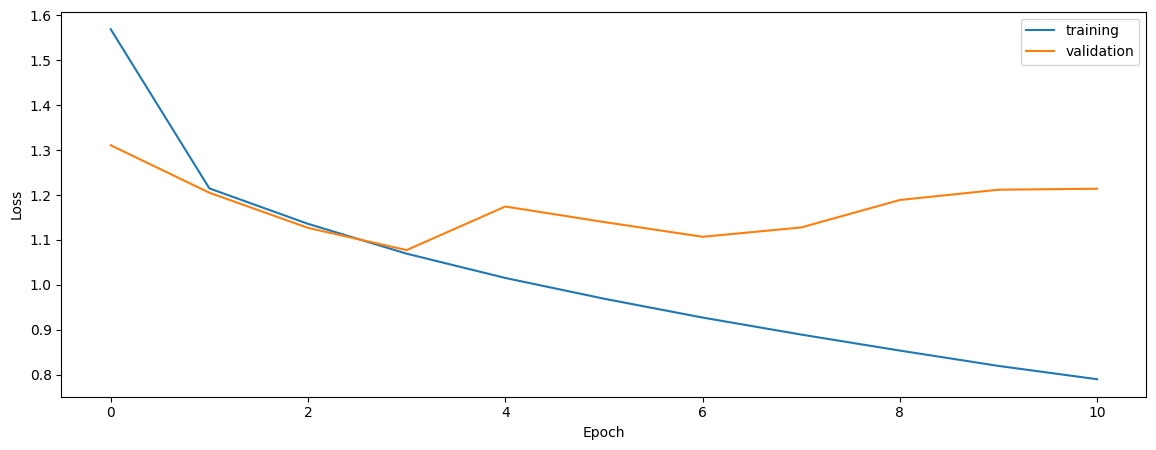

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.5915871916457989
0.5814942817644841
0.5280679811653914


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.571426616752047
0.5740415671956186
0.5439553042541734


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.570840784224878
0.5774022365454256
0.5546807445501297


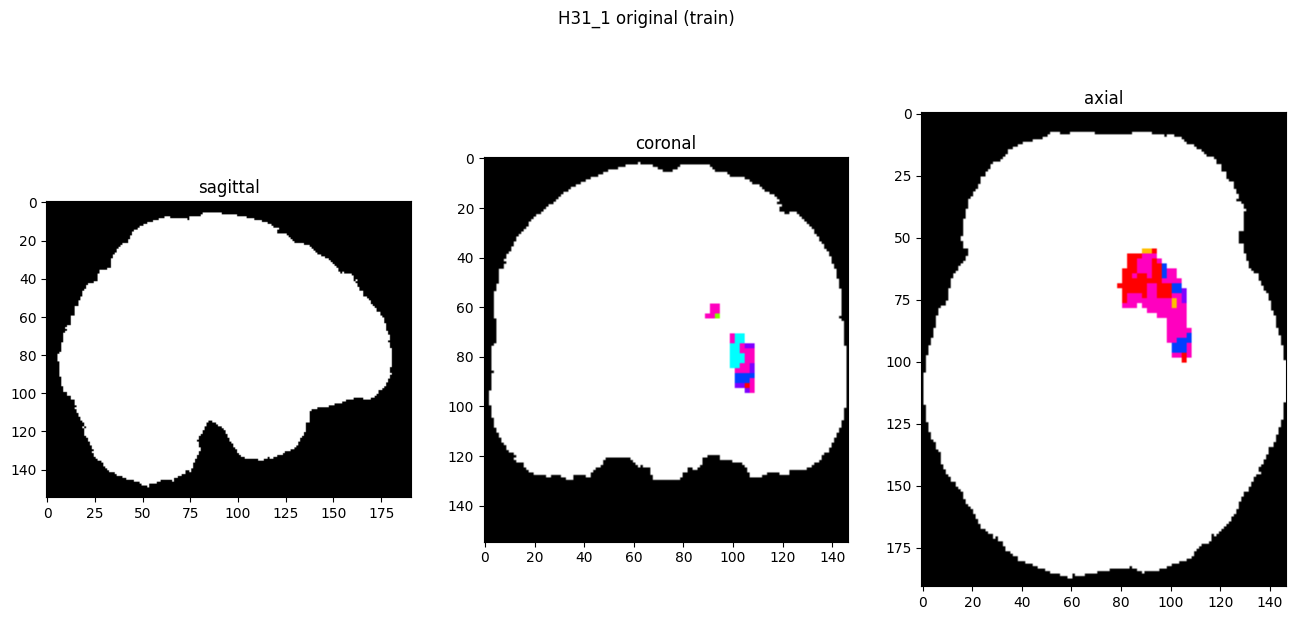

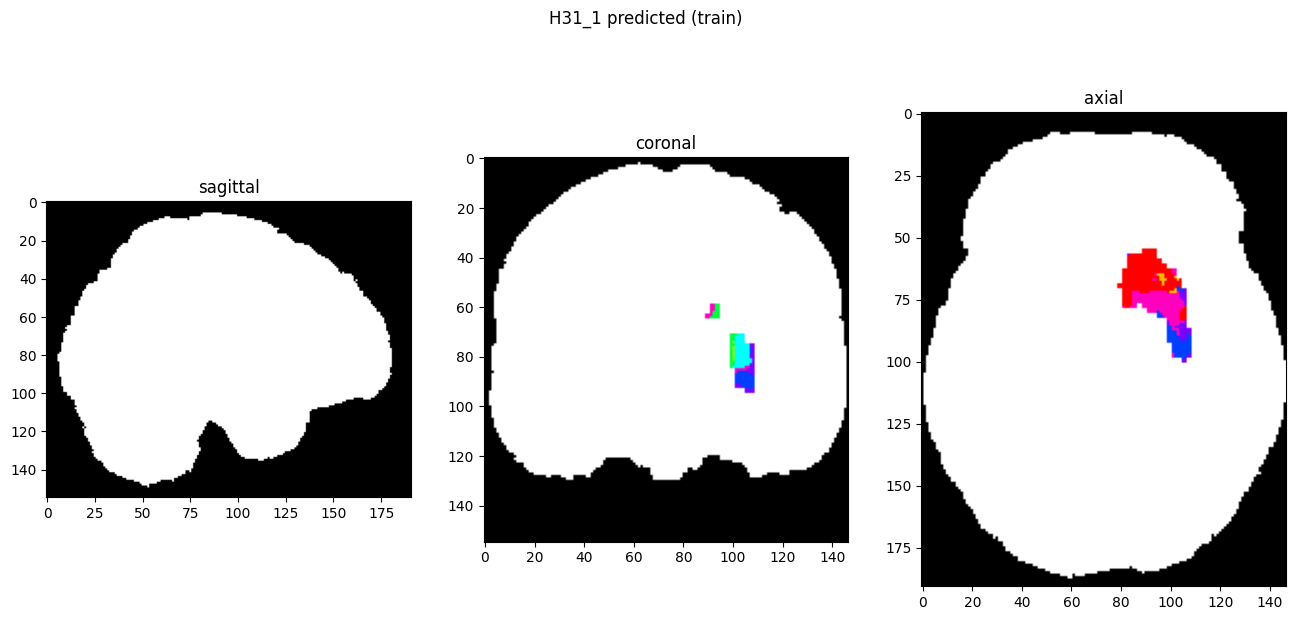

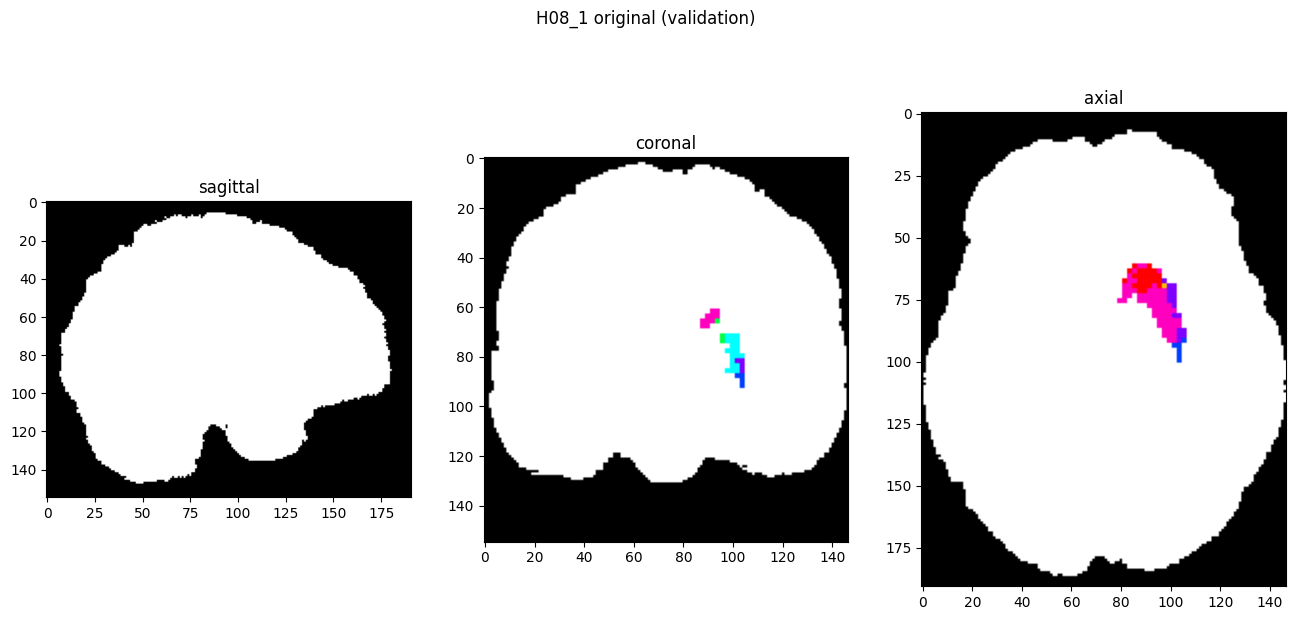

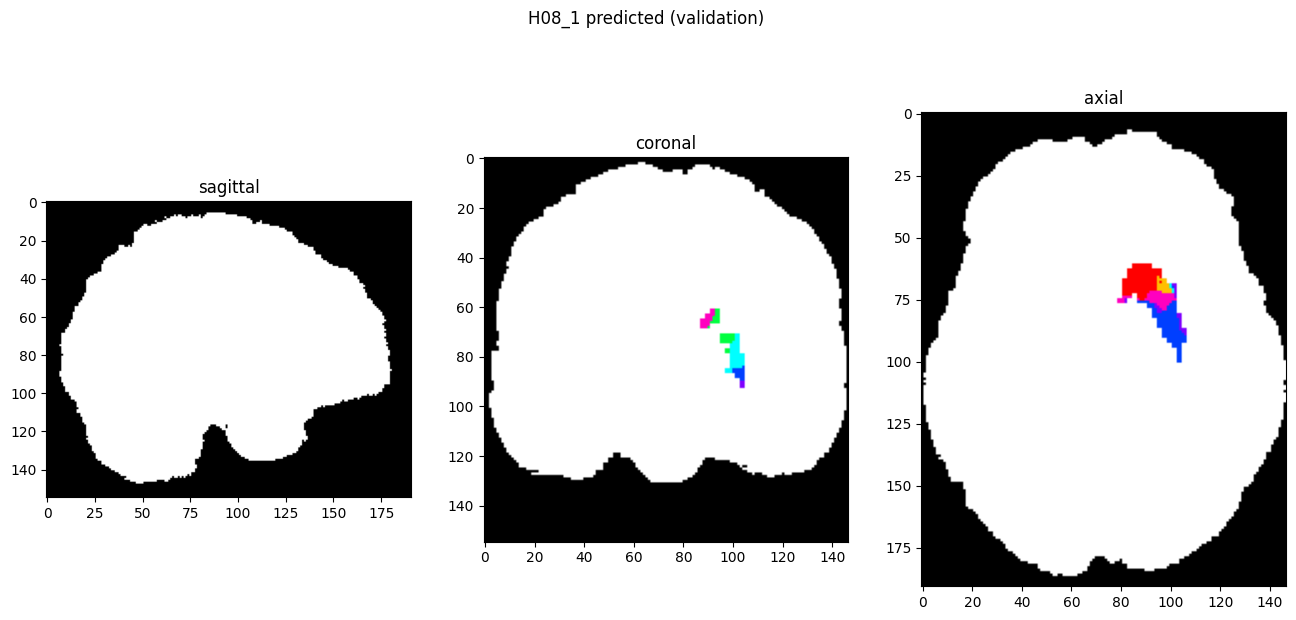

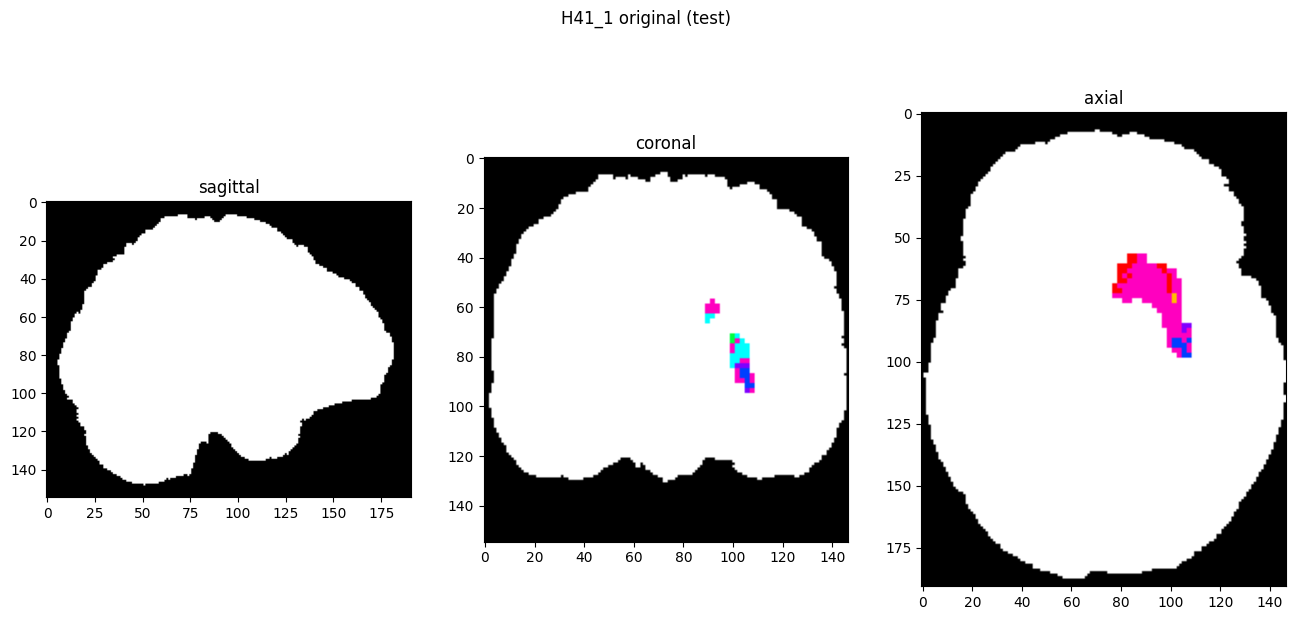

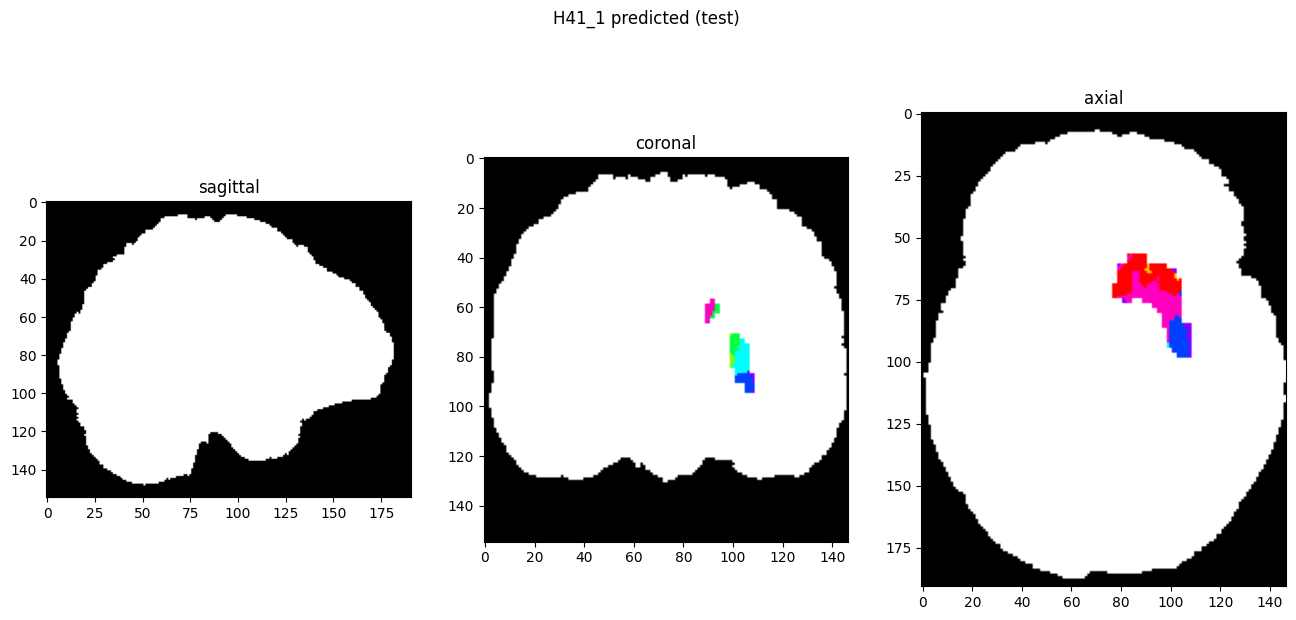

In [10]:
showResults(model, gen, threshold=0)